In [9]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from tools import *
from fit_funcs import *
from entropy import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe
import utils.tools as tools

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

linestyle_ls = ['-','--',':', '-.']
linestyle = itertools.cycle(linestyle_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists


config_disorder = 0
scaled_disorder = 1

if config_disorder:
    base_dir = "../results_conf_dis/"
else:
    base_dir = "../results/"

print(base_dir[2:])
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

/Users/rafal.swietek/Projects/CODES/QHamSolver/QuantumSun/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
/results/


In [13]:
L_total=15

J=1
alfa=1.0
h=0.0
w=0.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

scaled_disorder = 1

w_vals = np.unique( np.round( np.array( [ *np.linspace(0.4, 1.35, 20), *np.linspace(0.7, 0.82, 13)] ), 3) )
print(w_vals)

sizes = np.arange(8, 17, 1)


for nu in [500, 0.25, 0.5, 1.0]:
    frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

    folder_base = f'./collected data_scaled disorder/' if scaled_disorder else f'./collected data/'
    folder = folder_base + base_dir[3:] + f"nu={nu}/"
    os.makedirs(folder_base, exist_ok=True)
    os.makedirs(folder, exist_ok=True)

    for L_total in sizes:
        sub_sizes = np.arange(0, L_total+1)
        L = L_total - N
        name_out = folder + "_L=%g,N=%g,J=%g,gamma=%g,alfa=%g.hdf5"%(L, N, J, gamma, alfa)
        
        entropy         = np.zeros((sub_sizes.size, w_vals.size));  entropy     .fill(np.nan)
        entropy_site    = np.zeros((sub_sizes.size, w_vals.size));  entropy_site.fill(np.nan)
        gap_ratio       = np.zeros((w_vals.size));                  gap_ratio   .fill(np.nan)
        realisations    = np.zeros((w_vals.size));                  realisations.fill(np.nan)
        Sinfo_vN        = np.zeros((w_vals.size));                  Sinfo_vN.fill(np.nan)
        for ii, w in enumerate(w_vals):
            name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
            # if not exists(name): 
            #     name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5', scaled_disorder=scaled_disorder)
            #print(name)
            exist_S_vn = 1
            if exists(name):
                with h5py.File(name, "r") as file:
                        energies = np.array(file.get('mean energies'))
                        ratio = np.array(file.get('gap ratio'))
                        realis = np.array(file.get('realisations'))[0]
                        realisations[ii] = realis
                        if J != 1.0:
                            Sinfo = np.array(file.get('von Neumann participation entropy'))
                        
                        
                        dim = energies.size
                        num = frac(dim)
                        # print(dim, num)
                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        
                        my_min = int(index_meanE - num / 2)
                        if num == dim or my_min < 0: my_min = 0;  

                        my_max = int(index_meanE + num / 2)
                        if num == dim or my_max >= dim: my_max = dim-1

                        # try:
                            # if num == 500:          gap_ratio[ii] = np.array(file.get('gap ratio 500'))
                            # elif num == dim//2:     gap_ratio[ii] = np.array(file.get('gap ratio D/2'))
                            # else:
                                # print("otherwise")
                        gap_ratio[ii] = np.mean(ratio[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(ratio)
                        if J != 1.0:
                            Sinfo_vN[ii] = np.mean(Sinfo[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(Sinfo)

                        for ii_LA in range(sub_sizes.size):
                            S = np.array(file.get('entropies'))[ii_LA]
                            Ssite = np.array(file.get('single_site_entropy'))[ii_LA]
                            entropy[ii_LA][ii]         = np.mean(S[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(S)
                            entropy_site[ii_LA][ii]    = np.mean(Ssite[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(Ssite)
                        # except TypeError:
                        #     print(ratio)
            else:
                print(name)

        if not np.all( np.isnan(realisations) ):
            print("SAVED:", name_out)
            # print(LA, entropy[LA])
            hf = h5py.File(name_out, 'w')
            hf.create_dataset('scaled disorder',        w_vals.shape,           data = w_vals)
            hf.create_dataset('gap_ratio',              gap_ratio.shape,        data = gap_ratio)
            hf.create_dataset('entropy',                entropy.shape,          data = entropy)
            hf.create_dataset('single_site_entropy',    entropy_site.shape,     data = entropy_site)
            hf.create_dataset('realisations',           realisations.shape,     data = realisations)
            hf.create_dataset('vN info entropy',        Sinfo_vN.shape,         data = Sinfo_vN)
            hf.close()

[0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25
 1.3  1.35]
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=0.4.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=0.45.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=0.5.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=0.55.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=0.6.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=0.65.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=0.85.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=0.9.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=0.95.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=1.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=1.05.hdf5
../results/Entropy/Eigenstate/_L=5,N=3,J=1,g=1,alfa=1,h=0,W'=1.1.hdf5
..

[0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05
 1.1  1.15 1.2  1.25 1.3 ]


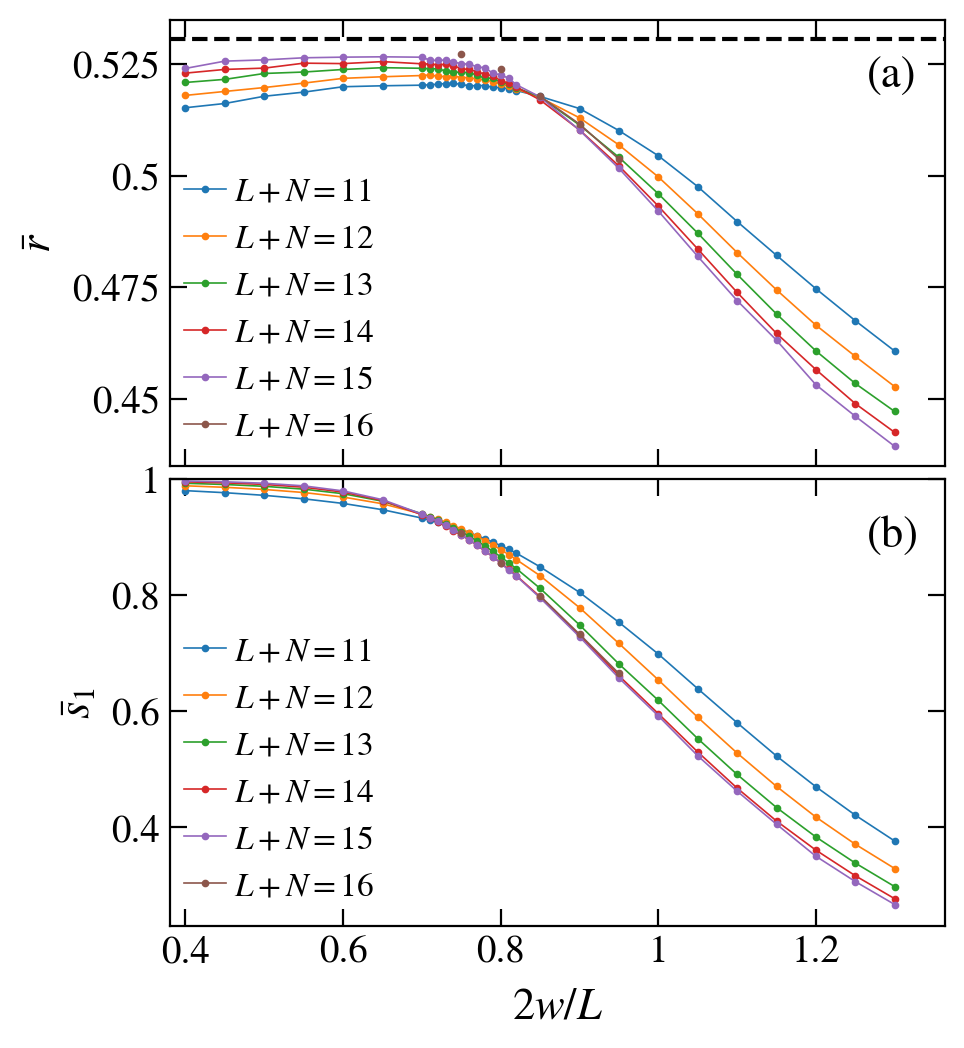

In [11]:
L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.4, 1.3, 19)
print(w_vals)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(5,6), dpi = 200, sharex=True)

sizes = np.arange(11, 17, 1)

rescale = 0

p = 2

nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data_scaled disorder/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)
    
xlab = r"$2w/L$"    
ylab = r"$\bar{r}$"

ps = [0, 1]
for idx1, p in enumerate(ps):
    
    disorder = []
    ydata = []
    for L_total in sizes:
        sub_sizes = np.arange(0, L_total+1)
        L = L_total - N
        LA = L_total - p if p > 0 else N
        name_out = folder + "_L=%g,N=%g,J=%g,gamma=%g,alfa=%g.hdf5"%(L, N, J, gamma, alfa)

        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                w_vals       = np.array(file.get('scaled disorder'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
                disorder.append(w_vals)
                # ydata.append(gap_ratio if idx1 == 0 else entropy[LA] / page(LA, L_total - LA))
                ydata.append(gap_ratio if idx1 == 0 else entropy[LA] / page(p, L_total - p))
        else:
            print(name_out)
  
    for ii, L in enumerate(sizes - N):
        axis[idx1].plot(disorder[ii], ydata[ii], marker='o', markersize=1.75, lw=0.6, label=r"$L+N=%d$"%(L+N))
        # axis[idx1].plot(rescale_fun(disorder[ii], sizes, ii, critical_fun, par, *crit_pars), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))

    axis[idx1].set_xlim(0.95*min(np.array(disorder).flatten()), 1.01*max(np.array(disorder).flatten()))

    # axis[idx1].axvline(x=0.7, ls='--', c='k', alpha=0.5)
    # axis[idx1].axvline(x=0.77, ls='-.', c='k', alpha=0.5)
    # axis[idx1].axvline(x=0.85, ls=':', c='k', alpha=0.5)
    fig_help.set_plot_elements(axis[idx1], ylabel=r"$\bar{s}_{%d}$"%p if p > 0 else r"$\bar{S}_A^{N}$", xlabel=xlab, font_size=14, set_legend=False)
    fig_help.set_legend(axis[idx1], loc = 'center left', fontsize=12, anchor=(-0.02, 0.35))
# axis[0].axhline(y=0.3863, ls='--', color='black')
axis[0].set_ylim(None, 0.535)
axis[0].axhline(y=0.5307, ls='--', color='black')

axis[1].set_ylim(None, 1)
# axis[2].set_ylim(None, 1)
# axis[3].set_ylim(None, 1)

fig_help.set_plot_elements(axis[0], ylabel=r"$\bar{r}$", xlabel="", font_size=14, set_legend=False)
fig_help.set_legend(axis[0], loc = 'center left', fontsize=12, anchor=(-0.02, 0.35))

if config_disorder:
    for ax in axis.flatten():
        ax.set_xscale('log')

for aa in [axis]:
    for ax in np.array(aa).flatten():
        ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

axis[0].annotate(r"(a)", fontsize=16, xy=(0.9, 0.85), xycoords='axes fraction')
axis[1].annotate(r"(b)", fontsize=16, xy=(0.9, 0.85), xycoords='axes fraction')
# axis[2].annotate(r"(c)", fontsize=16, xy=(0.9, 0.85), xycoords='axes fraction')
# axis[3].annotate(r"(d)", fontsize=16, xy=(0.9, 0.85), xycoords='axes fraction')
# axis[0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)

fig.subplots_adjust(wspace = 0.2, hspace=0.03)
plt.savefig("plots/FigA1.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("plots/FigA1.png", bbox_inches = 'tight', pad_inches=0.02)

## ENTROPY

### BIPARTITIE

../results/Entropy/Eigenstate/_L=10,N=5,J=1,g=1,alfa=1,h=0,W'=0.5_beta.hdf5
../results/Entropy/Eigenstate/_L=10,N=5,J=1,g=1,alfa=1,h=0,W'=0.75_beta.hdf5
../results/Entropy/Eigenstate/_L=10,N=5,J=1,g=1,alfa=1,h=0,W'=1.3_beta.hdf5


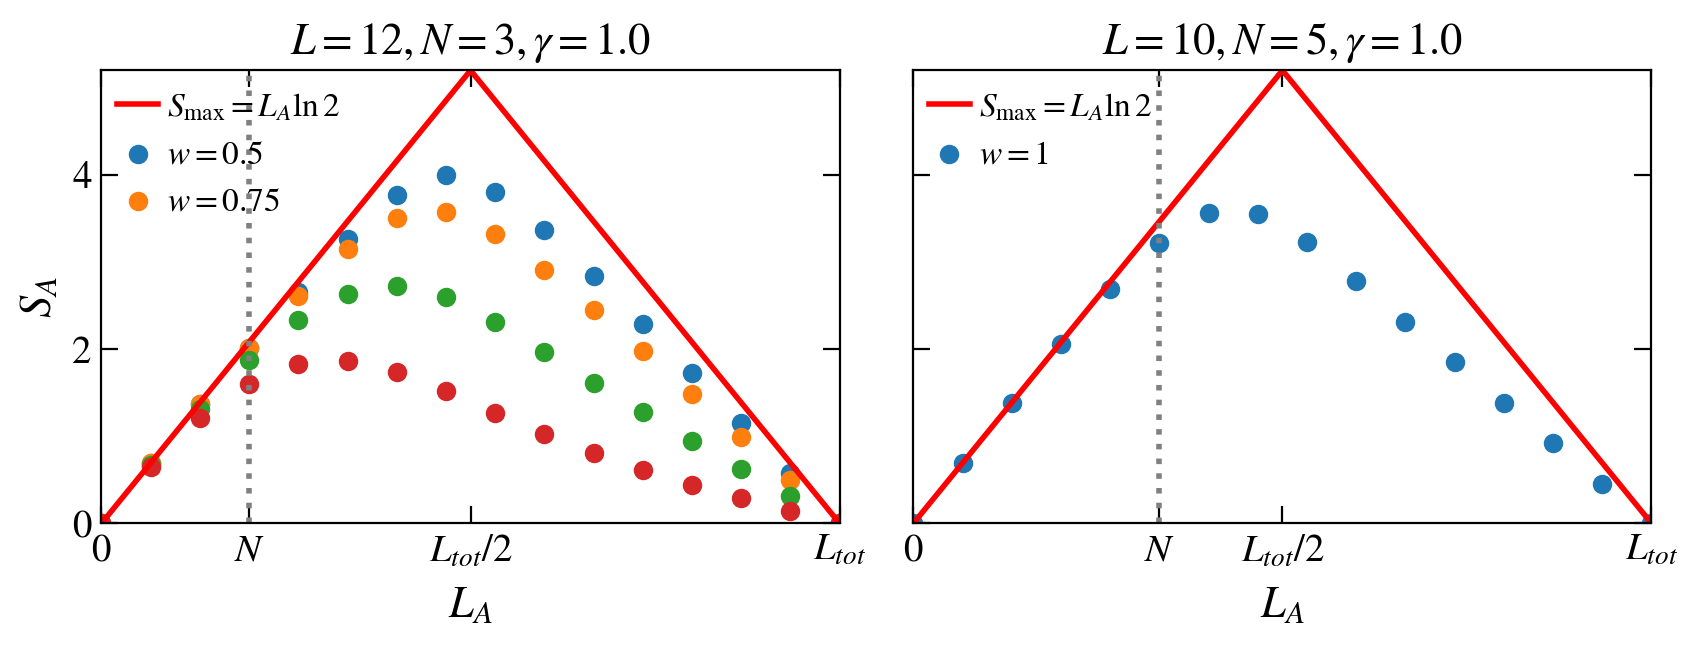

In [17]:

L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0

zeta=0.0
N=3
gamma=1.0
ini_ave=0

w_vals = np.linspace(0.5, 20., 40)

sub_sizes = np.arange(0, L_total+1)

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(10,3), dpi = 200, sharey=True)

def frac(dim):
    return 2*dim

w_vals = [0.5, 0.75, 1.0, 1.3]

Ns = [3, 5]
for iiii, axis in enumerate(axes):
    N = Ns[iiii]
    L = L_total - N
    for w in w_vals:
        name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
        if not exists(name): name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5', scaled_disorder=scaled_disorder)
        entropy = np.zeros((L_total+1))
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('mean energies'))
                ratio = np.array(file.get('gap ratio'))
                entropies = np.array(file.get('entropies'))
                
                dim = energies.size
                num = frac(dim)

                E_av = np.mean(energies)
                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                
                for LA in sub_sizes:
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = entropies[LA]
                    if my_min > 0 and my_max < dim:
                        sample = entropies[LA][my_min : my_max]
                    
                    entropy[LA] = np.mean(sample)
                    
            axis.scatter(sub_sizes, entropy, label=legend_label("w", w))
        else:
            print(name)
    laa = np.arange(0, L_total//2 + (L_total%2) + 0.5)
    axis.plot(laa, laa * np.log(2), c='red', lw=2)
    laa = np.arange(L_total//2, L_total + 1)
    axis.plot(laa, (L_total - laa)*np.log(2), c='red', lw=2, label=r"$S_{\rm max}=L_A\ln2$")

    axis.axvline(x=N, ls=':', color='gray', lw=2)
    fig_help.set_plot_elements(axis, ylabel=r"$S_A$" if iiii == 0 else "", xlabel=r"$L_A$", font_size=14, set_legend=True)
    axis.set_xlim(0, L_total)
    axis.set_ylim(0, L_total/2 * np.log(2))

    xticks = [0, N, L_total/2, L_total]
    tick_labels = ["$0$", "$N$", "$L_{tot}/2$", "$L_{tot}$"]
    axis.set_xticks(xticks)
    axis.set_xticklabels(tick_labels)
    axis.set_title(r"$L=%d, N=%d, \gamma=%.1f$"%(L,N, gamma), fontsize=16)

    handles, labels = axis.get_legend_handles_labels()

    split_idx = 3
    if iiii == 0:    axis.legend(handles=handles[:split_idx], labels=labels[:split_idx], loc = 'upper left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,1.02))
    else:            axis.legend(handles=handles[split_idx:], labels=labels[split_idx:], loc = 'upper left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,1.02))
    # plt.gca().add_artist(l1)
fig.subplots_adjust(wspace = 0.1, hspace=0.05)

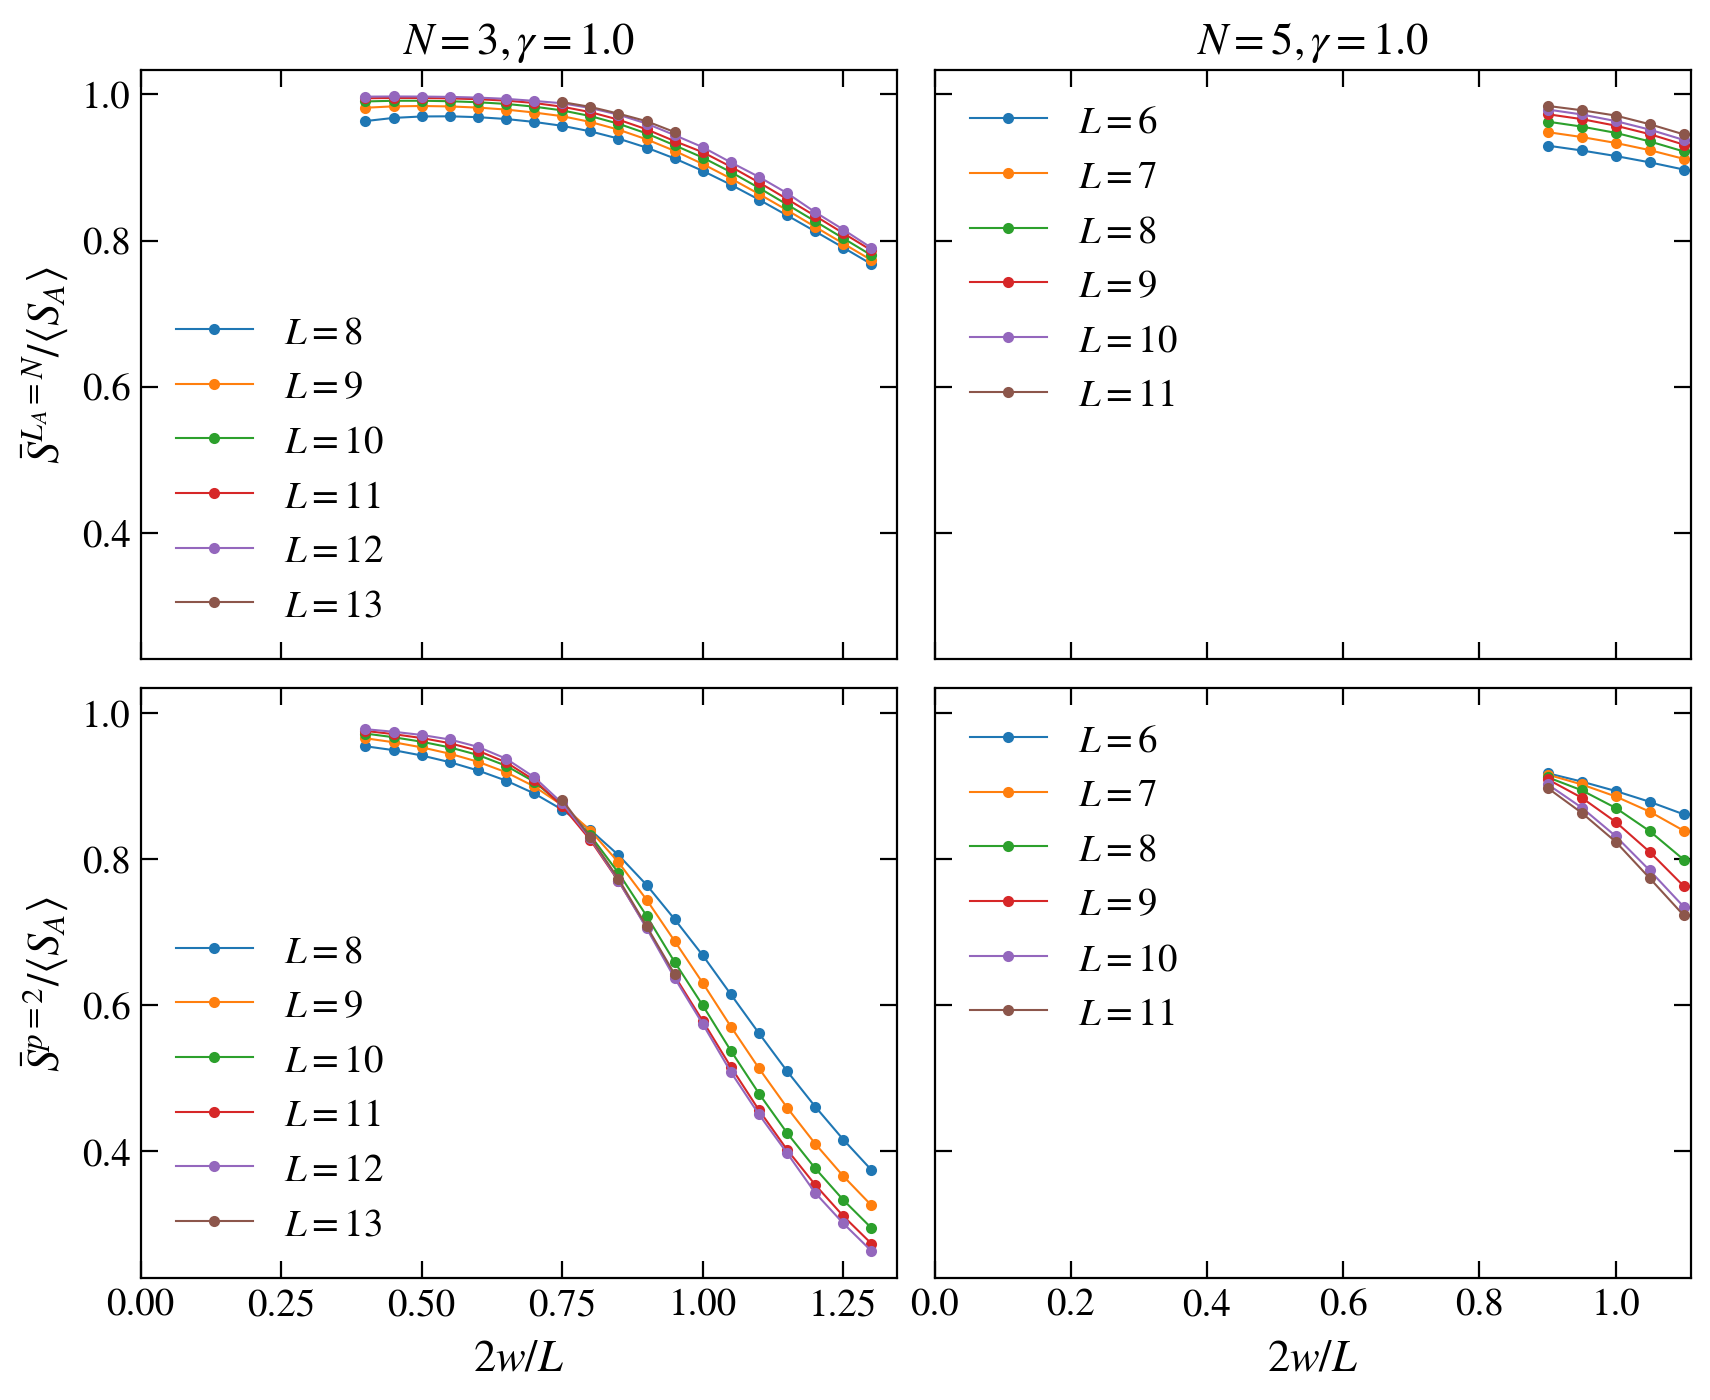

In [3]:
L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.75, 0.95, 5)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,8), dpi = 200, sharey=True)


nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data_scaled disorder/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

for idx1, N in enumerate([3, 5]):
    for L_total in np.arange(11, 17, 1):
        L = L_total - N
        name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                w_vals       = np.array(file.get('scaled disorder'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
            for idx2, LA in enumerate([N, L_total - 2]):
                axis[idx2][idx1].plot(w_vals, entropy[LA] / page(LA, L_total - LA), marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
                    # axis[idx2][idx1].set_ylim(1 / L**(b - 1),3 / L**(b - 1))
                if not config_disorder: axis[idx2][idx1].set_xlim(0, None)
                # axis[idx2][idx1].set_xlim(0.0,2)
        else:
            print(name_out)


xlab = r"$2w / L$"
ylab = r"$\bar{S}^{p=2} / \langle S_A\rangle$"
fig_help.set_plot_elements(axis[1][0], ylabel=ylab, xlabel=xlab, font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[1][1], ylabel="", xlabel=xlab, font_size=14, set_legend=True)

ylab = r"$\bar{S}^{L_A=N} / \langle S_A\rangle$"
fig_help.set_plot_elements(axis[0][0], ylabel=ylab, xlabel="", font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[0][1], ylabel="", xlabel="", font_size=14, set_legend=True)


axis[0][0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[0][1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[0][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
# axis[1][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
fig.subplots_adjust(wspace = 0.05, hspace=0.05)

### SINGLE-SITE ENTROPY

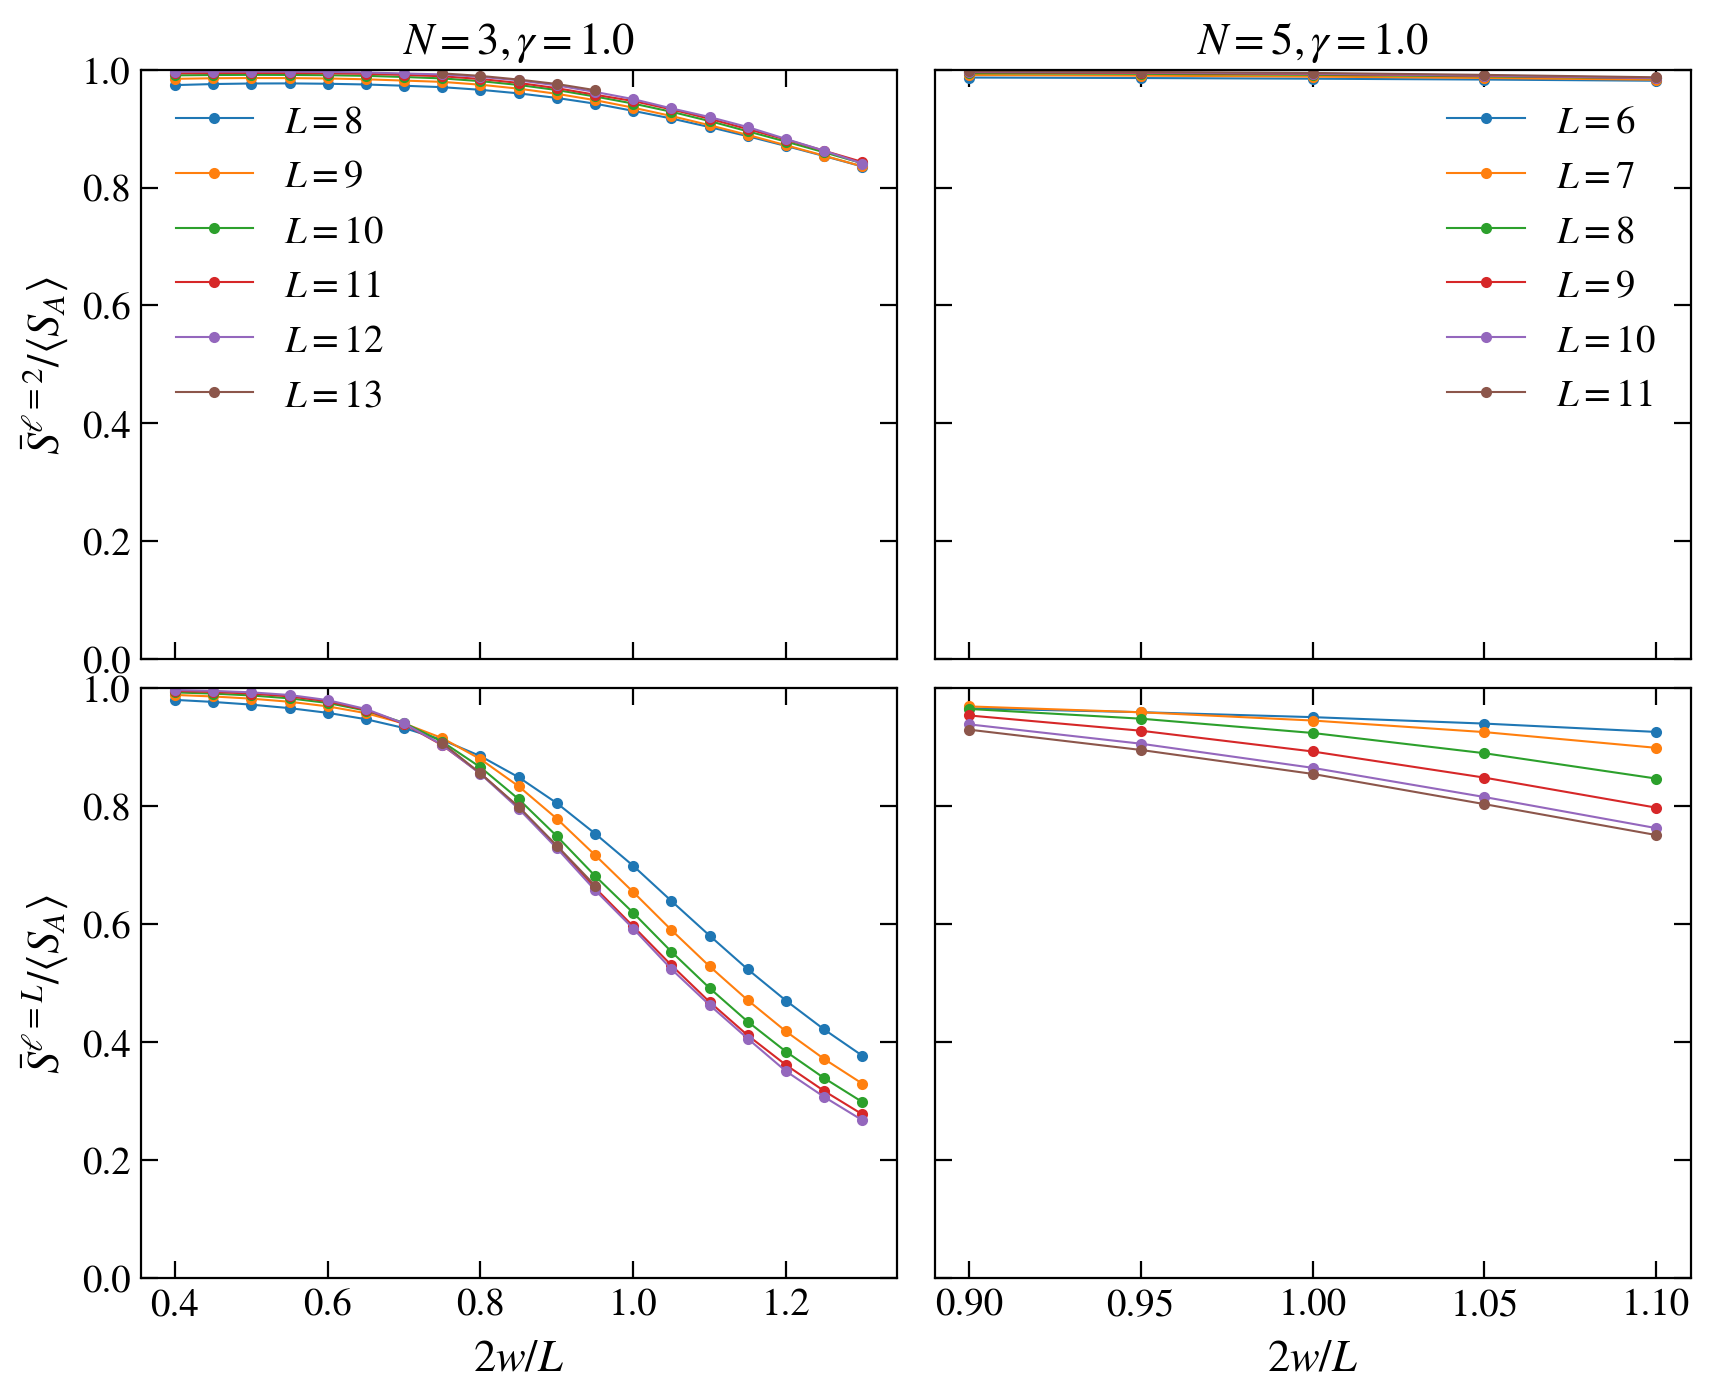

In [8]:
L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.4, 1.3, 19)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,8), dpi = 200, sharey=True)


nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data_scaled disorder/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"

# inset = []
# inset.append( axis[1][0].inset_axes([0.46, 0.46, 0.5, 0.5]) )
# inset.append( axis[1][1].inset_axes([0.46, 0.46, 0.5, 0.5]) )
for idx1, N in enumerate([3, 5]):
    for L_total in np.arange(11, 17):
        L = L_total - N
        name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                w_vals       = np.array(file.get('scaled disorder'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
            for idx2, ell in enumerate([N+1, L_total-1]):
                axis[idx2][idx1].plot(w_vals, entropy_site[ell] / page(1, L_total - 1), marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
                axis[idx2][idx1].set_ylim(0, 1)
                # if idx2 == 1:
                #     inset[idx1].plot(w_vals, entropy_site[ell] / page(1, L_total - 1), marker='o', markersize=3, lw=0.75)
                    
        else:
            print(name_out)
            # axis[idx2][idx1].set_xlim(0, 3.0)
fig_help.set_plot_elements(axis[1][0], ylabel=r"$\bar{S}^{\ell=L} / \langle S_A\rangle$", xlabel=r"$2w/L$", font_size=14, set_legend=False, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[1][1], ylabel=r"", xlabel=r"$2w/L$", font_size=14, set_legend=False, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[0][0], ylabel=r"$\bar{S}^{\ell=2} / \langle S_A\rangle$", xlabel="",         font_size=14, set_legend=True, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[0][1], ylabel=r"", xlabel="",         font_size=14, set_legend=True, yscale='linear', xscale='linear')

# inset[0].set_ylim(0.8, 1)
# inset[0].set_xlim(0.6, 1.0)
# inset[0].axvline(x=0.75, ls='--', c='k')

# inset[1].set_ylim(0.9, 1)
# inset[1].set_xlim(0.6, 1.)
# inset[1].axvline(x=0.75, ls='--', c='k')

axis[0][0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[0][1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[0][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
# axis[1][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
fig.subplots_adjust(wspace = 0.05, hspace=0.05)

#### ENTANGLEMENT CORRELATION LENGTH

ValueError: array must not contain infs or NaNs

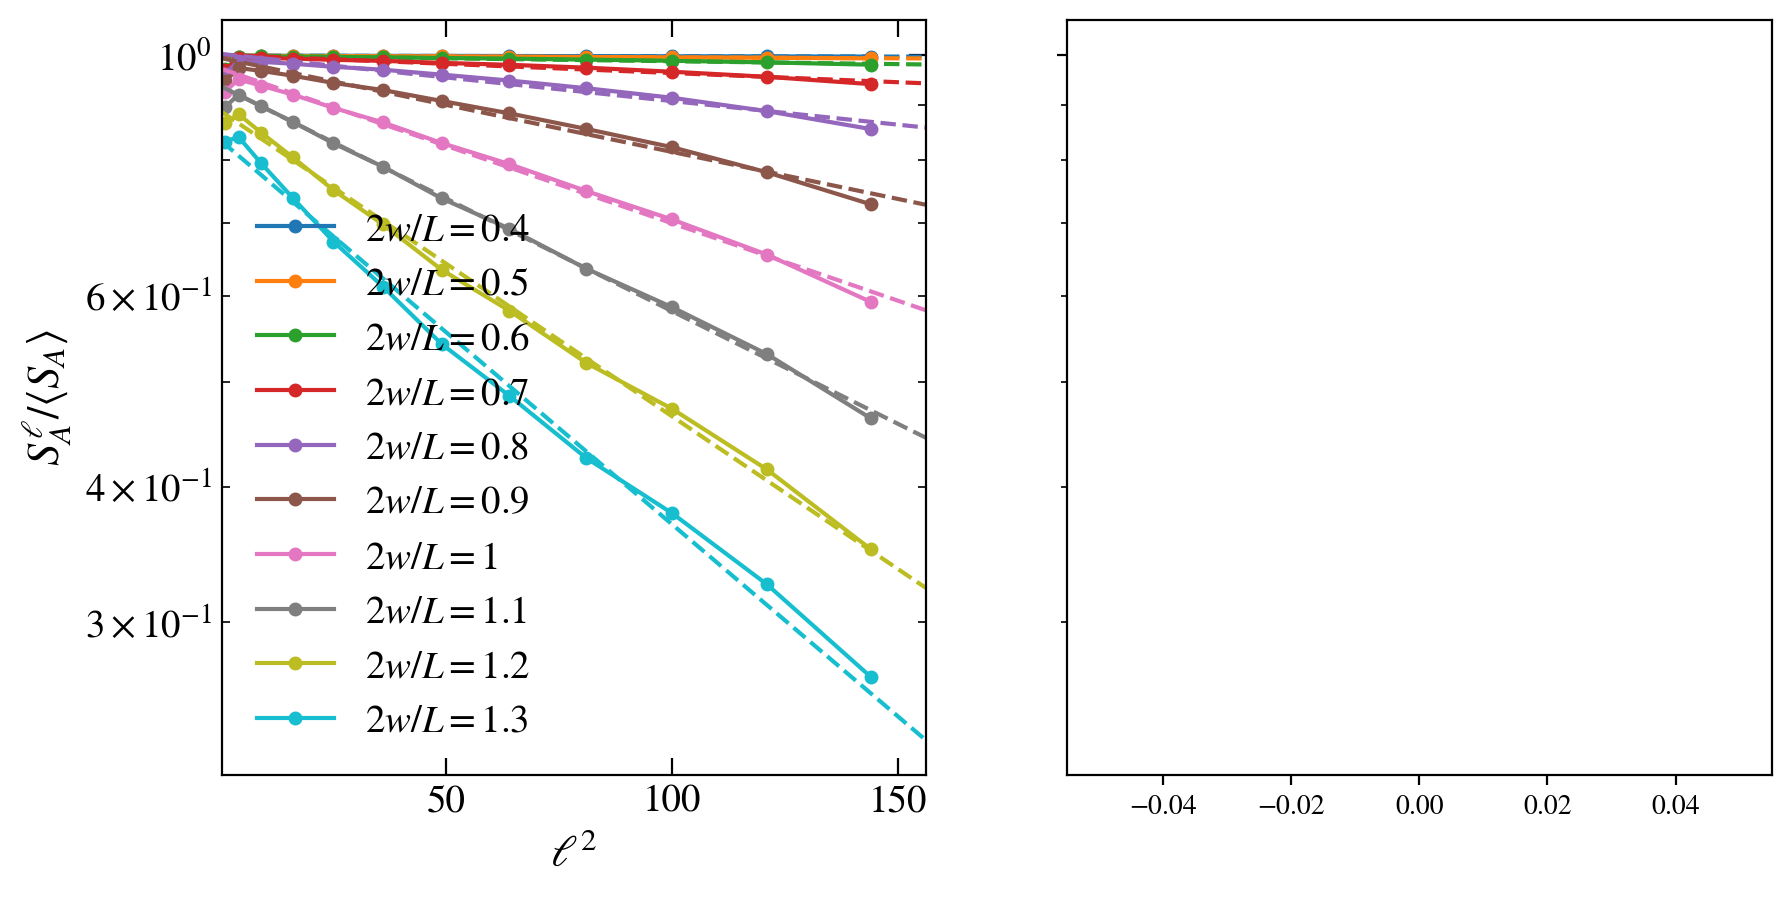

In [4]:
L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0


wx = np.linspace(0.4, 1.3, 10)

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True)

nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data_scaled disorder/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"

for idx1, N in enumerate([3, 5]):
    sub_sizes = np.arange(N, L_total)

    L = L_total - N
    colors = plt.cm.jet(np.linspace(0, 1, sub_sizes.size - 2))

    name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            w_vals       = np.array(file.get('scaled disorder'))
            gap_ratio    = np.array(file.get('gap_ratio'))
            entropy      = np.array(file.get('entropy'))[N:-1]
            entropy_site = np.array(file.get('single_site_entropy'))[N:-1]

        for ii, w in enumerate(wx):
            idx = list(w_vals).index(w)
            
            xdata = (sub_sizes - N + 1)**2
            ydata = (np.transpose(entropy_site)[idx] / page(1, L_total - 1))
            plo = axis[idx1].plot(xdata, ydata, marker='o', markersize=4, label=legend_label("2w/L", w))
            pars, pconv = fit(exp_fit,
                            xdata = xdata[2:],
                            ydata = ydata[2:])
            
            xdata = np.linspace(0.5, L_total - N + 0.5, 100)**2
            axis[idx1].plot(xdata, exp_fit(xdata, *pars), ls='--', color=plo[0].get_color())
            xi = pars[0]
            # print(xi)
            axis[idx1].set_xlim(min(xdata), max(xdata))
    else:
        print(name_out)
        
    
    fig_help.set_plot_elements(axis[idx1], ylabel=r"$S^{\ell}_A / \langle S_A\rangle$" if idx1 == 0 else "", xlabel=r"$\ell^2$", 
                                    font_size=14, set_legend=not idx1, xscale = 'linear', yscale='log')


axis[0].set_title(r"$L=%d, N=3, \gamma=%.1f$"%(L_total - 3,gamma), fontsize=16)
axis[1].set_title(r"$L=%d, N=5, \gamma=%.1f$"%(L_total - 5,gamma), fontsize=16)
axis[0].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
axis[1].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
fig.subplots_adjust(wspace = 0.05, hspace=0.05)

./collected data_scaled disorder/results/nu=500/_L=7,N=5,gamma=1.0,alfa=1.0.hdf5
./collected data_scaled disorder/results/nu=500/_L=8,N=5,gamma=1.0,alfa=1.0.hdf5
./collected data_scaled disorder/results/nu=500/_L=9,N=5,gamma=1.0,alfa=1.0.hdf5
./collected data_scaled disorder/results/nu=500/_L=10,N=5,gamma=1.0,alfa=1.0.hdf5
./collected data_scaled disorder/results/nu=500/_L=11,N=5,gamma=1.0,alfa=1.0.hdf5


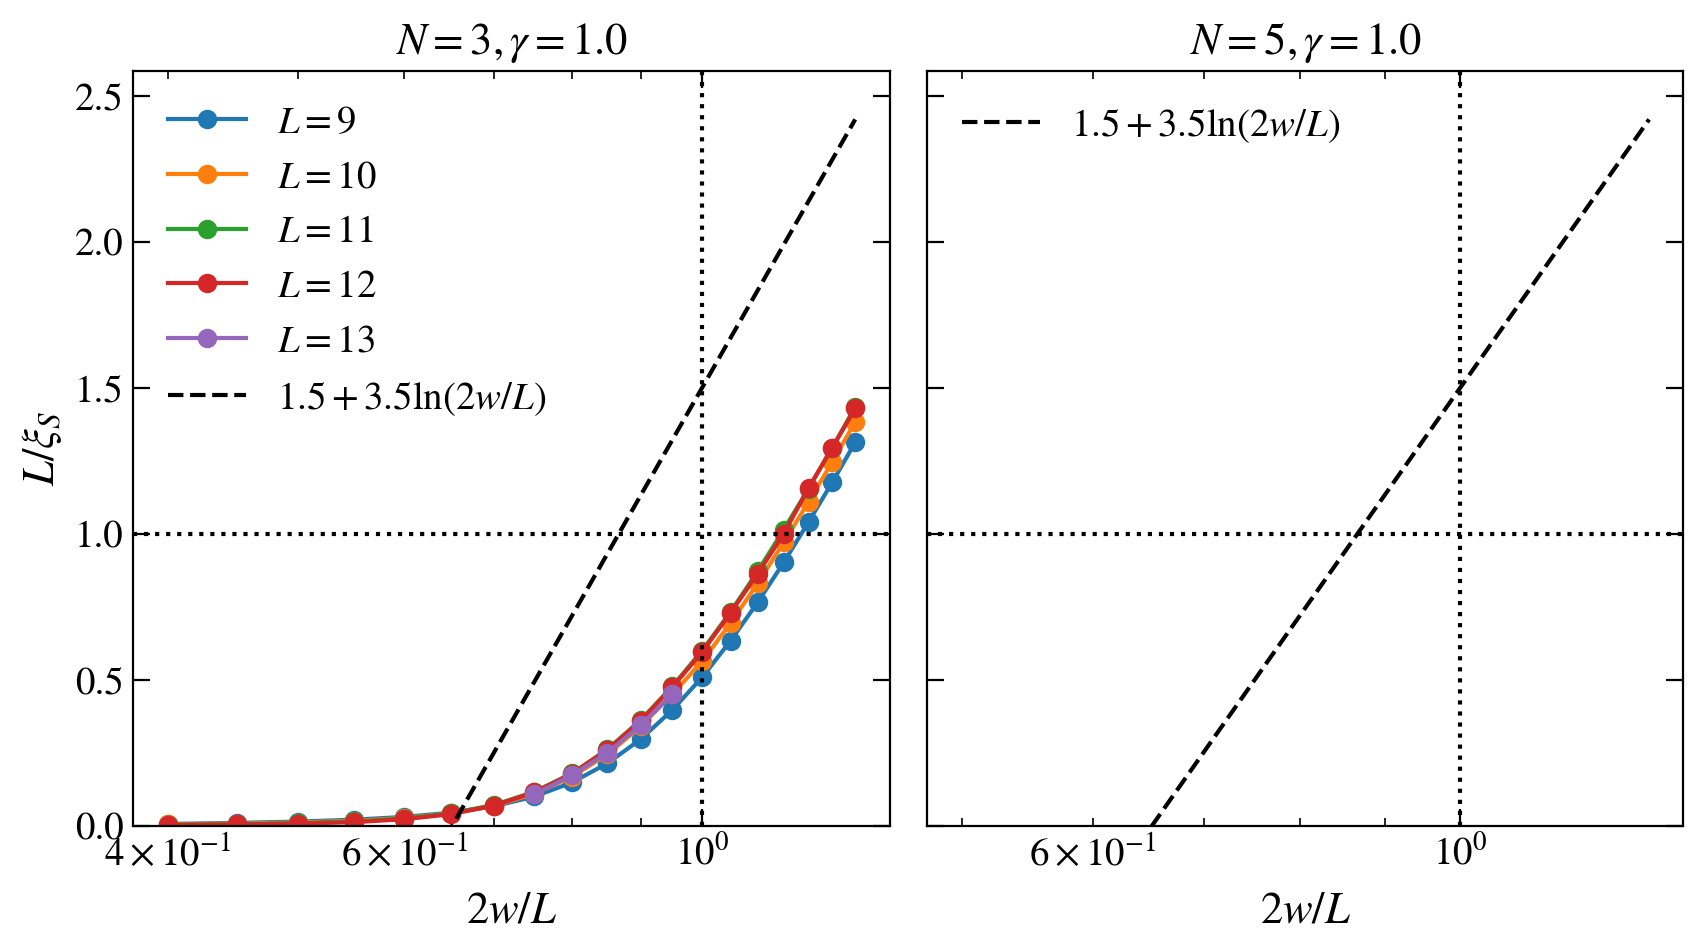

In [245]:
L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0

w_vals = np.linspace(0.4, 1.3, 19)

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True)

nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data_scaled disorder/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"

def rescale_xi(xi):
    return ( 1/xi )

for idx1, N in enumerate([3, 5]):
    for L_total in np.arange(12, 17, 1):
        sub_sizes = np.arange(N, L_total)

        L = L_total - N
        name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                w_vals       = np.array(file.get('scaled disorder'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))[N:-1]
                entropy_site = np.array(file.get('single_site_entropy'))[N:-1]
                # size = len(entropy_tmp)
                
                # entropy = np.zeros((sub_sizes.size, 34))
                # entropy_site = np.zeros((sub_sizes.size, 34))
                # for ii in range( size ):
                #     entropy[ii] = entropy_tmp[ii][w_vals > 3.0]
                #     entropy_site[ii] = entropy_site_tmp[ii][w_vals > 3.0]
                # w_vals = w_vals[w_vals > 3.0]

            colors = plt.cm.jet(np.linspace(0, 1, sub_sizes.size - 2))
            corr_len = np.zeros(w_vals.shape)
            for ii, w in enumerate(w_vals):
                
                xdata = sub_sizes - N + 1
                ydata = np.log(np.transpose(entropy_site)[ii] / page(1, L_total - 1))
                # print(ydata)
                # plo = axis[idx1].plot(xdata, ydata, marker='o', markersize=4, label=legend_label("w", w))
                if not np.any( np.isnan(ydata) ):
                    pars, pconv = fit(lin_fit,
                                    xdata = xdata[2:],
                                    ydata = ydata[2:])
                    # axis[idx1].plot(xdata, lin_fit(xdata, *pars), ls='--', color=plo[0].get_color())
                    xi = pars[0]
                    corr_len[ii] = xi
                    
            
            axis[idx1].plot(w_vals, rescale_xi( corr_len / L ), label=r"$L=%d$"%L, marker='o')

        else:
            print(name_out)
        
    axis[idx1].axhline(y=1.0, ls=':', c='k')
    axis[idx1].axvline(x=1.0, ls=':', c='k')

    xxx = np.linspace(0.5, 1.3, 100)
    axis[idx1].plot(xxx, 1.5 + 3.5*np.log(xxx), ls='--', c='k', label=r"$1.5+3.5\ln(2w/L)$")
    
    fig_help.set_plot_elements(axis[idx1], ylabel=r"$L/\xi_S$" if idx1 == 0 else "", xlabel=r"$2w/L$", font_size=14, set_legend=True, yscale='linear', xscale='log')
    axis[idx1].set_ylim(0, None)
    
axis[0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[0].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
# axis[1].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
fig.subplots_adjust(wspace = 0.05, hspace=0.05)

## SPECTRAL FORM FACTOR

Old file ../results/SpectralFormFactor/_L=7,N=3,J=1,g=1,alfa=1,h=0,W'=0.75.hdf5
Old file ../results/SpectralFormFactor/_L=8,N=3,J=1,g=1,alfa=1,h=0,W'=0.75.hdf5
Old file ../results/SpectralFormFactor/_L=9,N=3,J=1,g=1,alfa=1,h=0,W'=0.75.hdf5
Old file ../results/SpectralFormFactor/_L=10,N=3,J=1,g=1,alfa=1,h=0,W'=0.75.hdf5
Old file ../results/SpectralFormFactor/_L=11,N=3,J=1,g=1,alfa=1,h=0,W'=0.75.hdf5
Old file ../results/SpectralFormFactor/_L=12,N=3,J=1,g=1,alfa=1,h=0,W'=0.75.hdf5
0.75 13 (5000,)


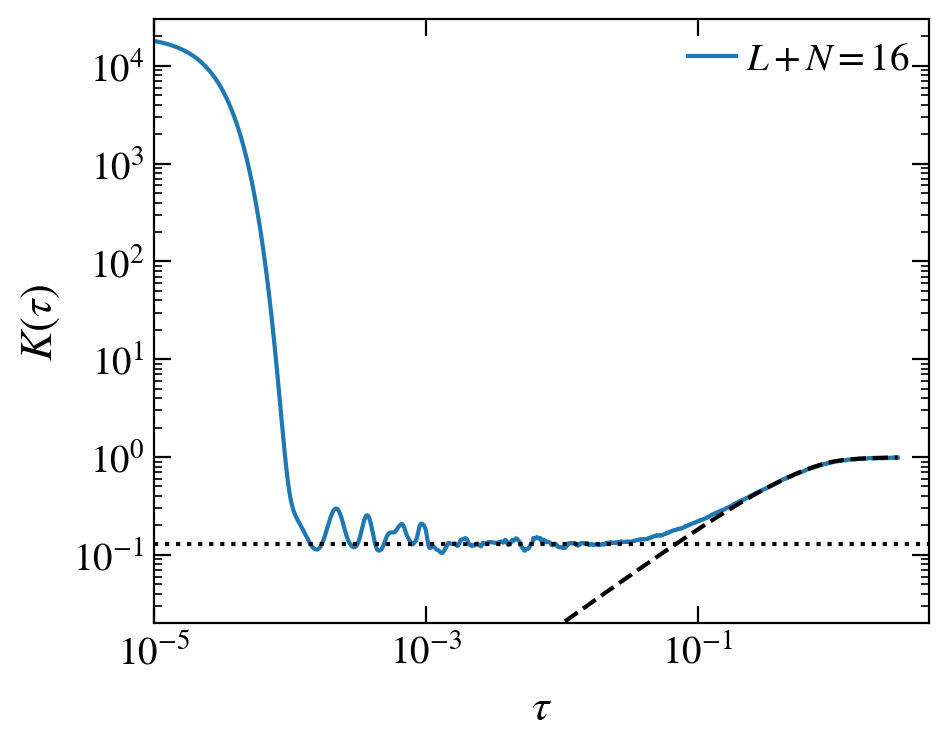

In [15]:
L_total=15
N=3

J=1.0
alfa=1.0
h=0.0
w=0.75
zeta=0.0
gamma=1.0
ini_ave=0
L = L_total - N

sizes = np.arange(10, 15, 1) - N

bucket = 50
folded = 0
running_mean = 1
eta=0.3

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,4), dpi = 200)

sizes = np.arange(10, 17, 1) - N

for L in sizes:
    name = base_dir + 'SpectralFormFactor/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
    if exists(name):
        with h5py.File(name, "r") as file:
            tHtyp = np.array(file.get('tH_typ'))[0]  / (2 * np.pi)
            times = np.array(file.get('times_fold')) / tHtyp if folded else np.array(file.get('times'))
            sff = np.array(file.get('sff_fold' if folded else "sff_eta=%.1f"%eta))
            try:
                if sff.shape == (1, 5000):
                    sff = sff[0]
                    times = times[0]
                    print(w, L, sff.shape)
                if running_mean: 
                    sff = tools.remove_fluctuations(sff, bucket)
                    sff = sff[bucket // 2 : -bucket // 2]
                    times = times[bucket // 2 : -bucket // 2]
                axis.plot(times, sff, label=r"$L+N=%d$"%(L+N))
            except TypeError:
                print("Old file", name)
    else:
        print(name)
axis.plot(times, goe.spectral_form_factor(times), ls='--', c='k')
# axis[0].set_ylim(0.38,0.54)

# axis[1].set_ylim(0.3 + 0.1*iabc,0.9)

fig_help.set_plot_elements(axis, ylabel=r"$K(\tau)$", xlabel=r"$\tau$", font_size=14, set_legend=False, xscale='log', yscale='log', ylim=(2e-2,3e4), xlim=(1e-5, 5))
fig_help.set_legend(axis, loc = 'upper right', fontsize=14, ncol=1)

axis.axhline(y=0.13, ls=':', c='k')
# fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)


fig.subplots_adjust(wspace = 0.05, hspace=0.3)
plt.savefig("plots/Fig1.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("plots/Fig1.png", bbox_inches = 'tight', pad_inches=0.02)

../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.5.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.6.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.7.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.74.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.76.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.77.hdf5


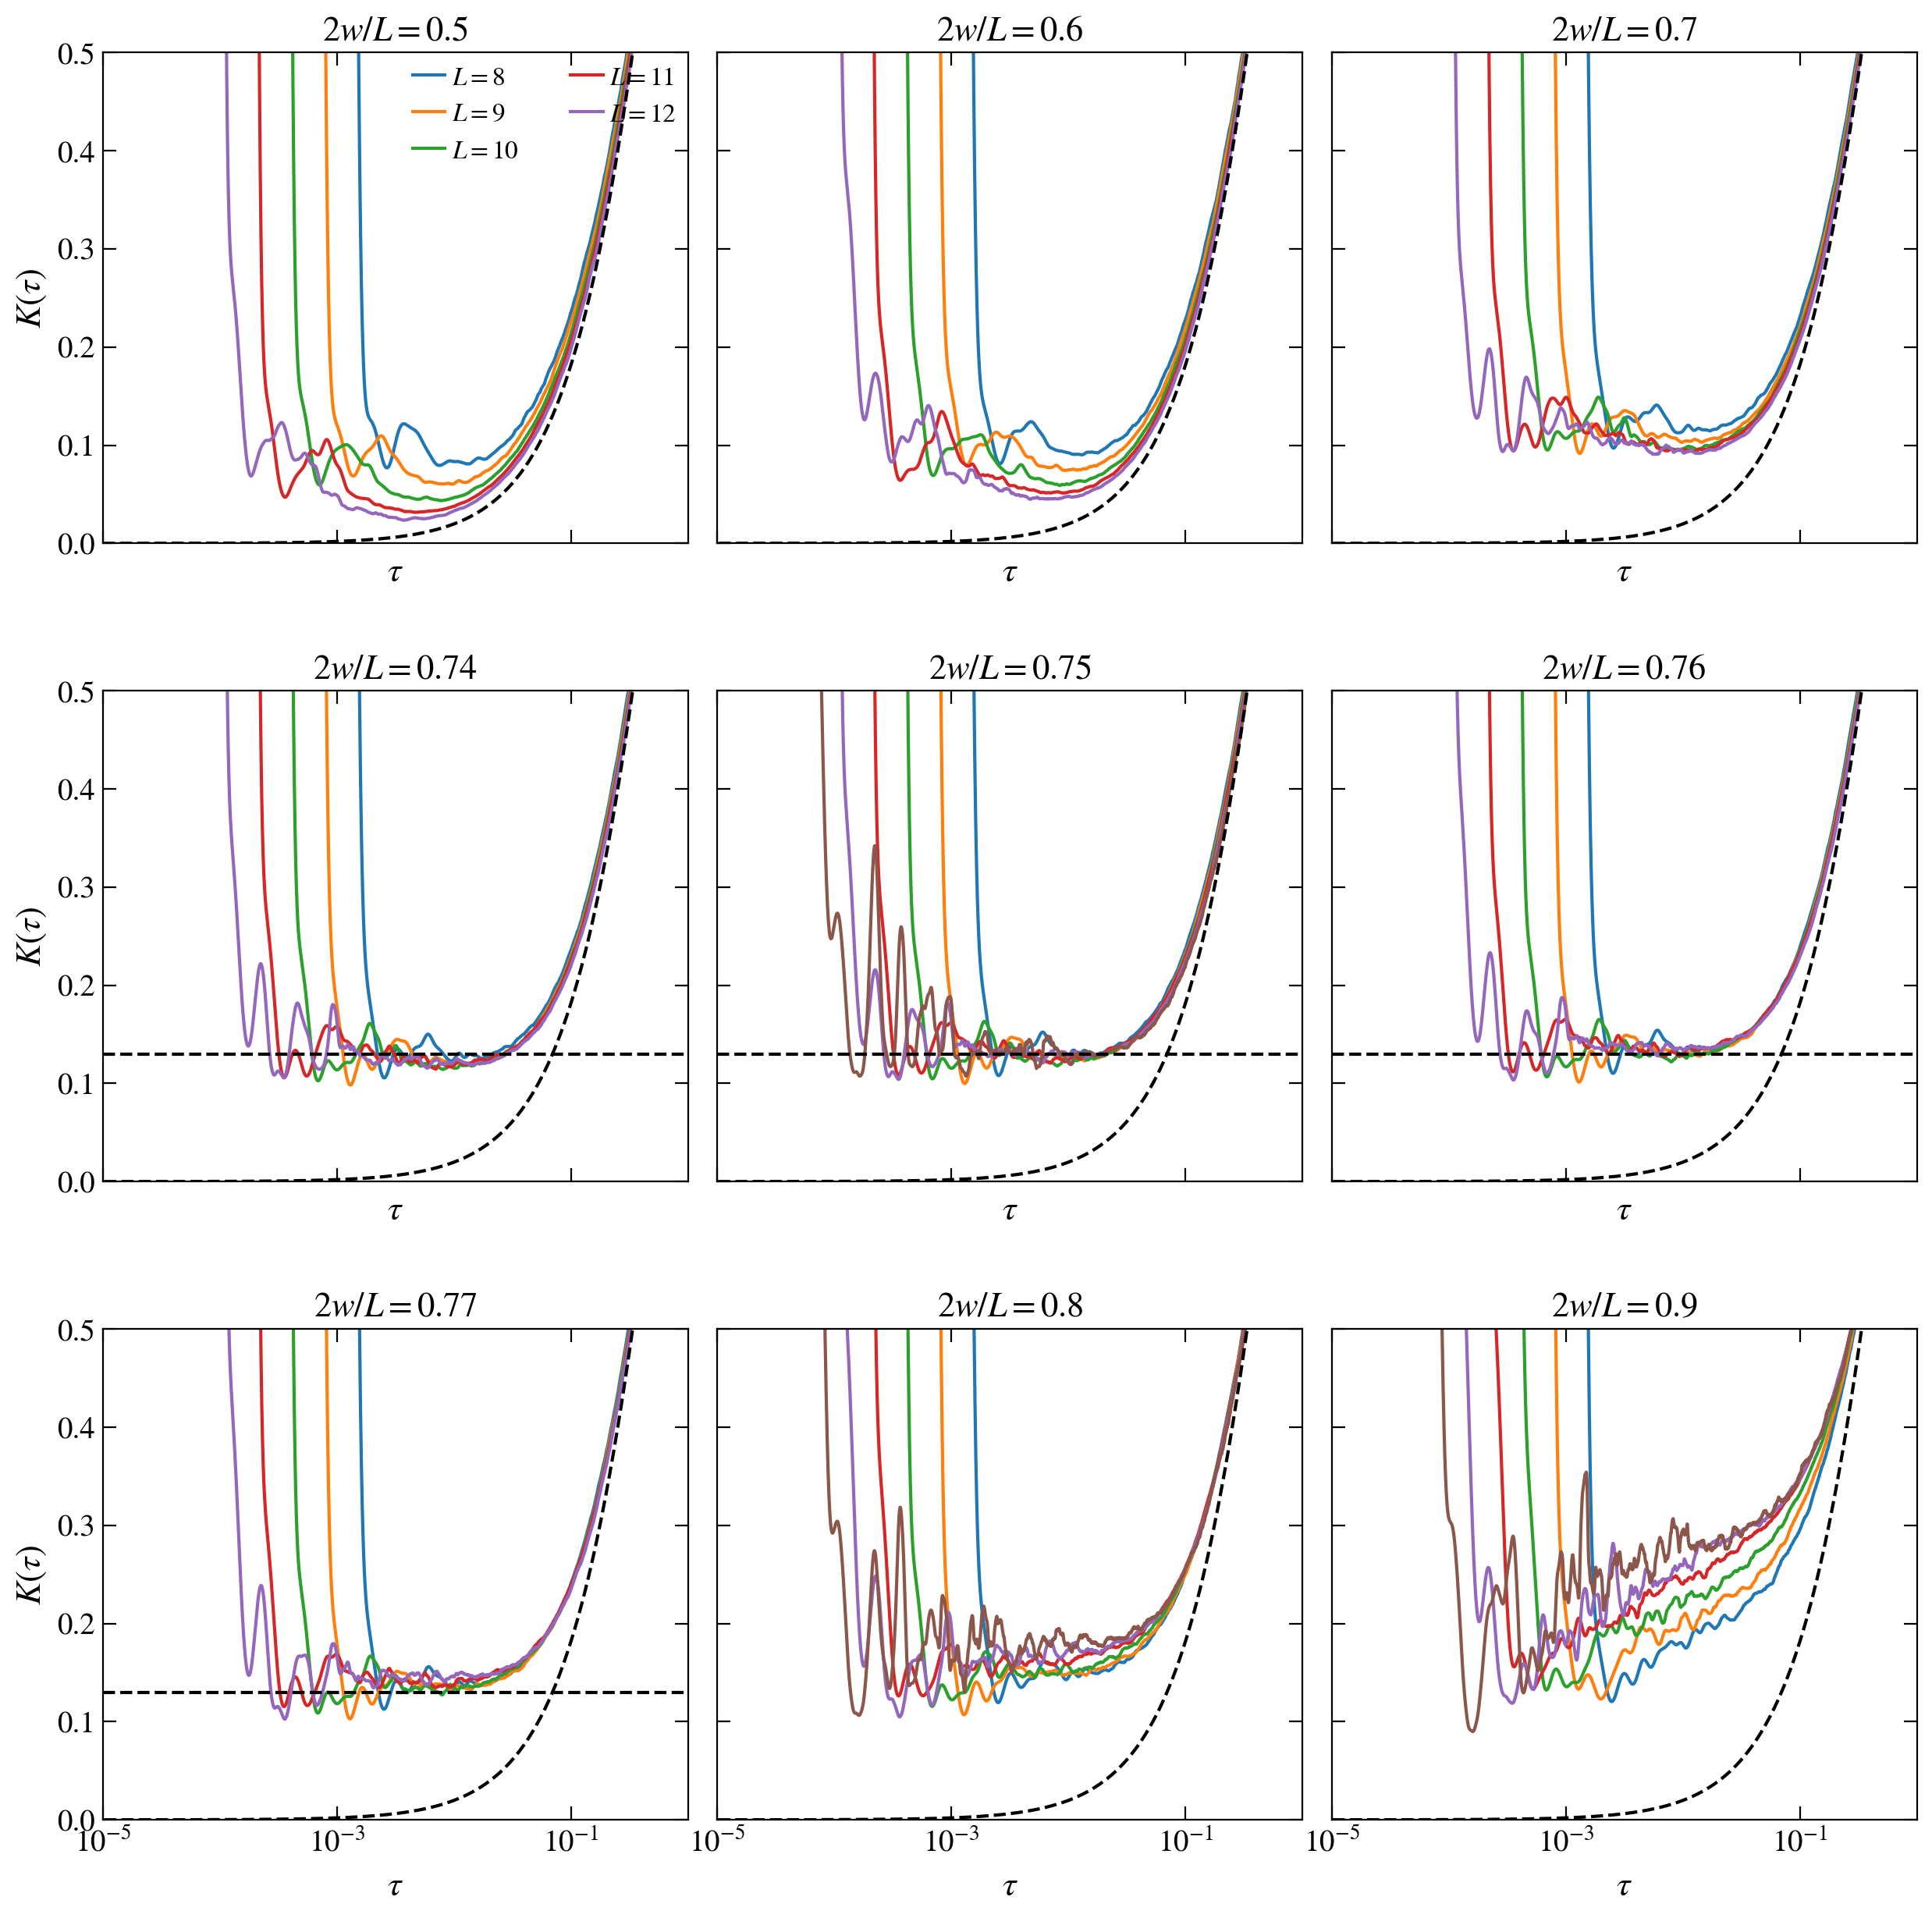

In [446]:
L_total=15
N=3

J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
gamma=1.0
ini_ave=0
L = L_total - N

sizes = np.arange(10, 15, 1) - N

bucket = 50
raw = 0
running_mean = 1
eta=0.5

fig, axis = plt.subplots( nrows=3, ncols=3, figsize=(15,15), dpi = 200, sharex=True, sharey='row')
axis = np.array(axis).flatten()

sizes = np.arange(11, 17, 1) - N
w_vals = [0.5, 0.6, 0.7, 0.74, 0.75, 0.76, 0.77, 0.8, 0.9] if N == 3 else [0.9, 1.0, 1.1]
for ii_w, w in enumerate(w_vals):
    for L in sizes:
        name = base_dir + 'SpectralFormFactor/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
        if exists(name):
            with h5py.File(name, "r") as file:
                tHtyp = np.array(file.get('tH_typ'))[0]
                times = np.array(file.get('times_fold')) / tHtyp if raw else np.array(file.get('times'))
                sff = np.array(file.get('sff_raw' if raw else "sff_eta=%.1f"%eta))
                
                if sff.shape == (1, 5000):
                    sff = sff[0]
                    times = times[0]
                    # print(w, L, sff.shape)
                if running_mean: 
                    sff = tools.remove_fluctuations(sff, bucket)
                    sff = sff[bucket // 2 : -bucket // 2]
                    times = times[bucket // 2 : -bucket // 2]
                axis[ii_w].plot(times, sff, label=r"$L=%d$"%L)
        else:
            print(name)
    axis[ii_w].plot(times, goe.spectral_form_factor(times), ls='--', c='k')
    # axis[0].set_ylim(0.38,0.54)

    # axis[1].set_ylim(0.3 + 0.1*iabc,0.9)

    fig_help.set_plot_elements(axis[ii_w], ylabel=r"$K(\tau)$" if ii_w % 3 == 0 else "", xlabel=r"$\tau$", font_size=14, set_legend=False, xscale='log', yscale='linear', ylim=(0., 0.5), xlim=(1e-5, 1))
    axis[ii_w].set_title(r"$2w/L=%g$"%w, fontsize=16)
    fig_help.set_legend(axis[0], loc = 'upper right', fontsize=12, ncol=2)

axis[3].axhline(y=0.13, ls='--', c='k')
axis[4].axhline(y=0.13, ls='--', c='k')
axis[5].axhline(y=0.13, ls='--', c='k')
axis[6].axhline(y=0.13, ls='--', c='k')
# fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)


fig.subplots_adjust(wspace = 0.05, hspace=0.3)

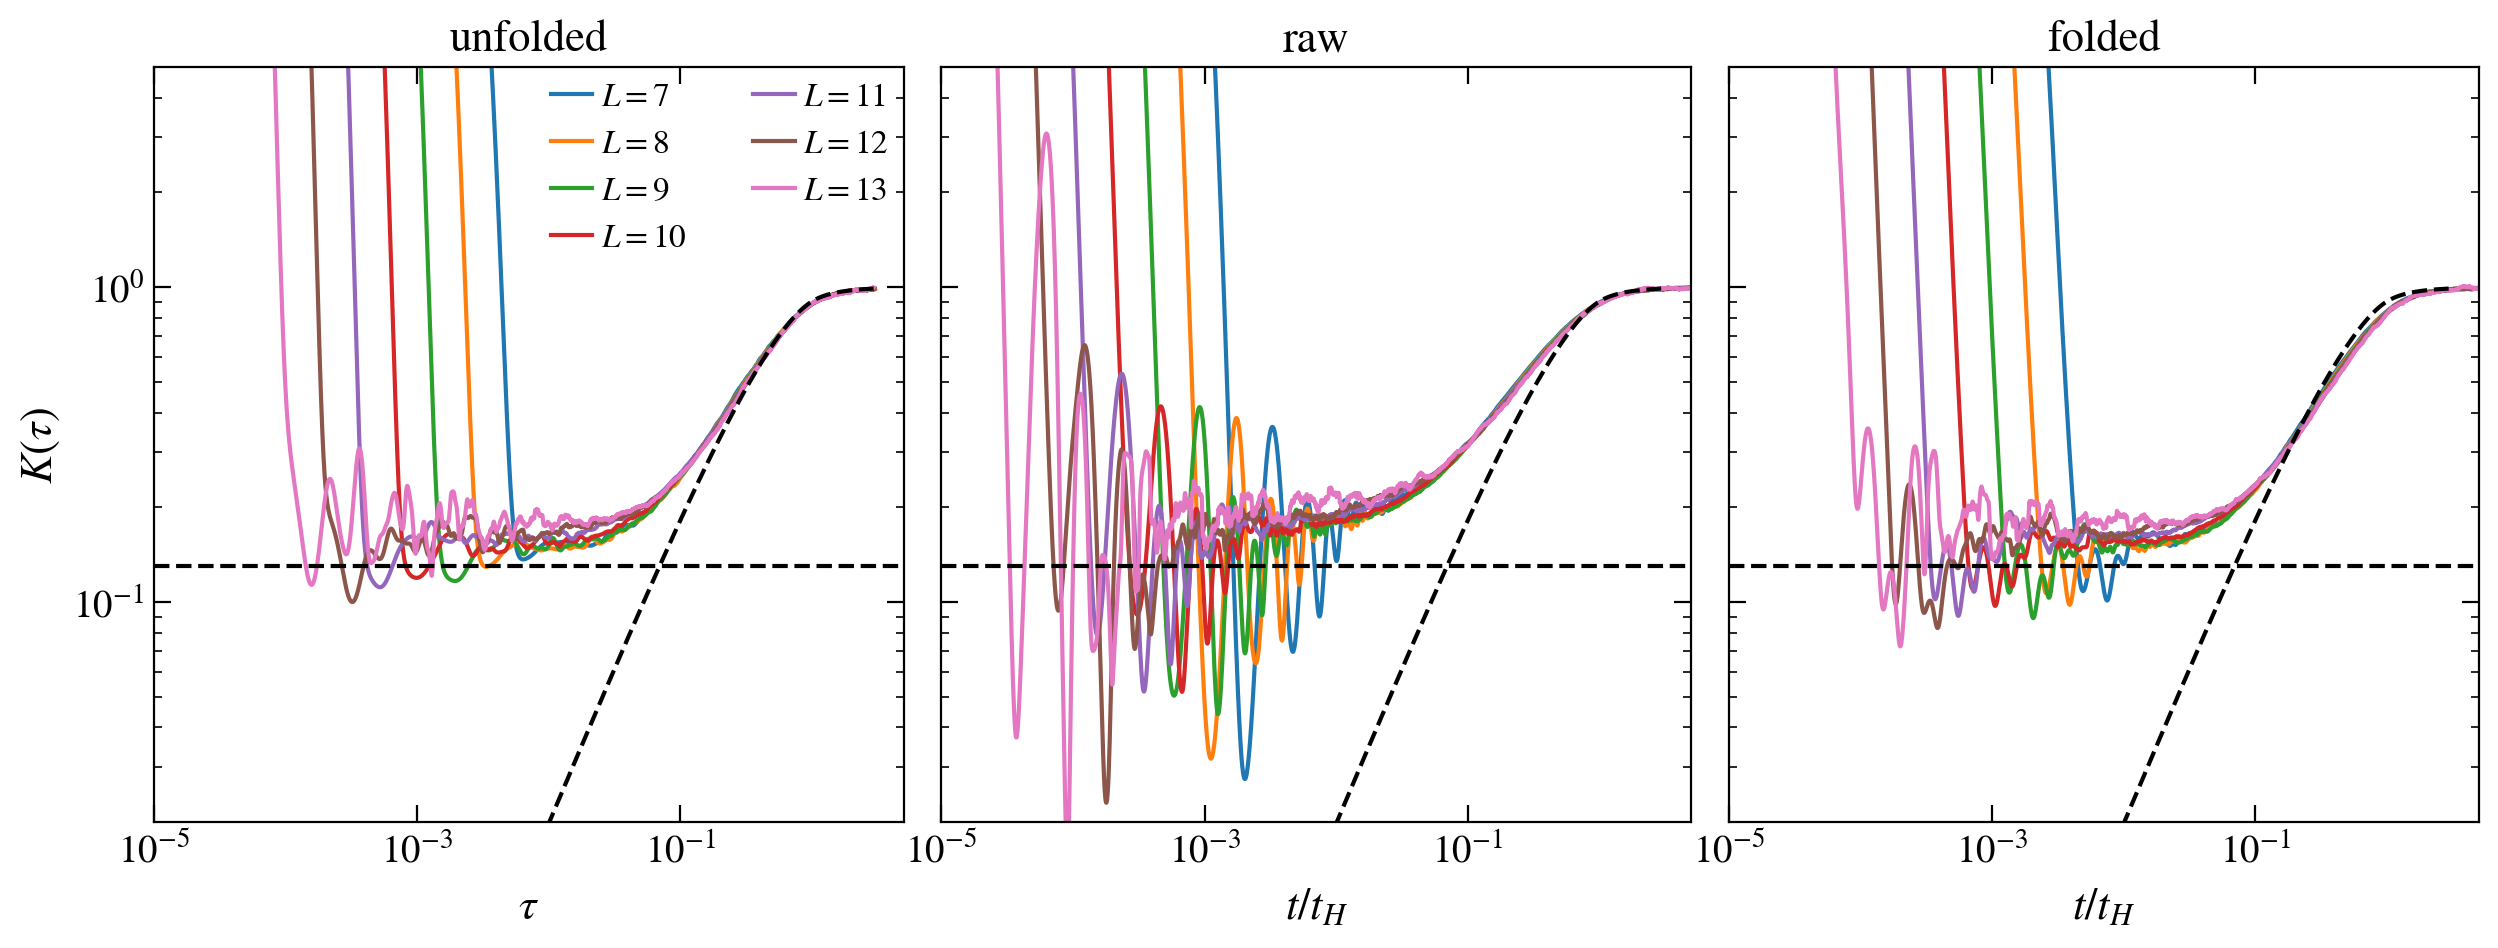

In [172]:
L_total=15
N=3

J=1.0
alfa=1.0
h=0.0
w=0.8
zeta=0.0
gamma=1.0
ini_ave=0
L = L_total - N
scaled_disorder=1

sizes = np.arange(10, 17, 1) - N

bucket = 50
running_mean = 1
eta=0.3

fig, axis = plt.subplots( nrows=1, ncols=3, figsize=(15,5), dpi = 200, sharex=True, sharey='row')

for L in sizes:
    name = base_dir + 'SpectralFormFactor/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
    if exists(name):
        with h5py.File(name, "r") as file:
            tHtyp = np.array(file.get('tH_typ'))[0]
            times = np.array(file.get('times'))
            times_fold = np.array(file.get('times_fold')) / tHtyp
            
            sff = np.array(file.get("sff_eta=%.1f"%eta))
            try:
                sff_raw = np.array(file.get('sff_raw'))
                sff_fold = np.array(file.get('sff_fold'))
                if sff_raw.size > 1:
                    if sff.shape == (1, 5000):
                        sff = sff[0]
                        sff_raw = sff_raw[0]
                        sff_fold = sff_fold[0]
                        times = times[0]
                        times_fold = times_fold[0]
                    if running_mean: 
                        sff = tools.remove_fluctuations(sff, bucket)[bucket // 2 : -bucket // 2]
                        sff_raw = tools.remove_fluctuations(sff_raw, bucket)[bucket // 2 : -bucket // 2]
                        sff_fold = tools.remove_fluctuations(sff_fold, bucket)[bucket // 2 : -bucket // 2]
                        times = times[bucket // 2 : -bucket // 2]
                        times_fold = times_fold[bucket // 2 : -bucket // 2]
                    
                    axis[0].plot(times, sff, label=r"$L=%d$"%L)
                    axis[1].plot(times_fold, sff_raw)
                    axis[2].plot(times_fold * (2.0 * np.pi), sff_fold)
            except IndexError:
                print(name)
            
    else:
        print(name)
axis[0].plot(times, goe.spectral_form_factor(times), ls='--', c='k')
axis[1].plot(times, goe.spectral_form_factor(times), ls='--', c='k')
axis[2].plot(times, goe.spectral_form_factor(times), ls='--', c='k')
# axis[0].set_ylim(0.38,0.54)

# axis[1].set_ylim(0.3 + 0.1*iabc,0.9)

for ijk, ax in enumerate(axis):
    fig_help.set_plot_elements(ax, ylabel=r"$K(\tau)$" if ijk == 0 else "", xlabel=r"$\tau$" if ijk == 0 else r"$t/t_H$", font_size=14, set_legend=False, xscale='log', yscale='log', ylim=(2e-2,5e0), xlim=(1e-5, 5))
    ax.axhline(y=0.13, ls='--', c='k')
fig_help.set_legend(axis[0], loc = 'upper right', fontsize=12, ncol=2)
axis[0].set_title(r"unfolded", fontsize=16)
axis[1].set_title(r"raw", fontsize=16)
axis[2].set_title(r"folded", fontsize=16)

# axes[0][0].axhline(y=0.13, ls='--', c='k')
# fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)


fig.subplots_adjust(wspace = 0.05, hspace=0.3)

In [1]:
L_total=15
N=3

J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
gamma=1.0
ini_ave=0
L = L_total - N

sizes = np.arange(10, 17, 1) - N

bucket = 50
folded = 0
running_mean = 1
eta=0.1
epsilon=0.08

w_vals = np.linspace(0.4, 1.3, 19)
# w_vals = np.linspace(0.7, 0.82, 13)

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharex=True)

for ii_w, w in enumerate(w_vals):
    name = base_dir + 'SpectralFormFactor/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
    if exists(name):
        with h5py.File(name, "r") as file:
            tHtyp = np.array(file.get('tH_typ'))[0] / (2*np.pi)
            times = np.array(file.get('times_fold')) / tHtyp if folded else np.array(file.get('times'))
            sff = np.array(file.get('sff_folded' if folded else "sff_eta=%.1f"%eta))
            try:
                if sff.shape == (1, 5000):
                    sff = sff[0]
                    times = times[0]
                if running_mean: 
                    sff = tools.remove_fluctuations(sff, bucket)
                    sff = sff[bucket // 2 : -bucket // 2]
                    times = times[bucket // 2 : -bucket // 2]
                axis[0].plot(times, sff)

                sff = np.abs( np.log10(sff / goe.spectral_form_factor(times)) )
                idx = (np.abs(sff - epsilon)).argmin()

                pl = axis[1].plot(times, sff, label=r"$2w/L=%g$"%w)
                axis[1].scatter(times[idx], sff[idx], color=pl[0].get_color(), facecolor='None', s=20)
            except TypeError:
                print("Old file", name)
    else:
        print(name)
axis[0].plot(times, goe.spectral_form_factor(times), ls='--', c='k')
axis[1].axhline(y=epsilon, ls='--', c='k')

axis[0].axvline(x=1, ls=':', c='k')
axis[1].axvline(x=1, ls=':', c='k')
fig_help.set_plot_elements(axis[0], ylabel=r"$K(\tau)$", xlabel=r"$\tau$", font_size=14, set_legend=False, xscale='log', yscale='log', ylim=(1e-2,1e1), xlim=(1e-5, 5))
fig_help.set_plot_elements(axis[1], ylabel=r"$\Delta K(\tau)$", xlabel=r"$\tau$", font_size=14, set_legend=False, xscale='log', yscale='log', ylim=(1e-5,1e1), xlim=(1e-5, 5))
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=12, ncol=2)

# fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)


fig.subplots_adjust(wspace = 0.25, hspace=0.2)

NameError: name 'np' is not defined

In [176]:
L_total=15
N=3

J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
gamma=1.0
ini_ave=0
L = L_total - N
scaled_disorder=1

sizes = np.arange(10, 17, 1) - N

bucket = 50
folded = 0
running_mean = 1
epsilon=0.1
eta=0.3

w_vals = np.unique( np.round( np.array( [ *np.linspace(0.4, 1.3, 19), *np.linspace(0.7, 0.82, 13)] ), 3) )
w_vals = np.linspace(0.4, 1.3, 19)

folder = f'./thouless time_scaled disorder/'
os.makedirs(folder, exist_ok=True)

for L in sizes:
    t_Th    = np.zeros((w_vals.size))
    tH      = np.zeros((w_vals.size))
    tH_typ  = np.zeros((w_vals.size))
    name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
    for ii_w, w in enumerate(w_vals):
        name = base_dir + 'SpectralFormFactor/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
        if exists(name):
            with h5py.File(name, "r") as file:
                tH[ii_w]     = np.array(file.get('tH'))[0]
                tH_typ[ii_w] = np.array(file.get('tH_typ'))[0]
                tHtyp = np.array(file.get('tH_typ'))[0]
                times = np.array(file.get('times_fold')) * (2*np.pi) / tHtyp if folded else np.array(file.get('times'))
                sff = np.array(file.get('sff_folded' if folded else "sff_eta=%.1f"%eta))
                try:
                    if sff.shape == (1, 5000):
                        sff = sff[0]
                        times = times[0]
                    sff = tools.remove_fluctuations(sff, bucket)
                    sff = sff[bucket // 2 : -bucket // 2]
                    times = times[bucket // 2 : -bucket // 2]
                    sff = np.abs( np.log10(sff / goe.spectral_form_factor(times)) )
                    idx = (np.abs(sff - epsilon)).argmin()
                    
                    t_Th[ii_w] = times[idx]
                except TypeError:
                    t_Th[ii_w] = np.nan
                    print("Old file", name)
        else:
            print(name)
    hf = h5py.File(name_out, 'w')
    hf.create_dataset('scaled disorder',         w_vals.shape,  data = w_vals)
    hf.create_dataset('thouless time',           t_Th.shape,    data = t_Th)
    hf.create_dataset('heisenberg time',         tH.shape,      data = tH)
    hf.create_dataset('typical heisenberg time', tH_typ.shape,  data = tH_typ)
    hf.close()


../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.4.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.45.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.5.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.55.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.6.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.65.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=0.7.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=1.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=1.05.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=1.1.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=1.15.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=1.2.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=1.25.hdf5
../results/SpectralFormFactor/_L=13,N=3,J=1,g=1,alfa=1,h=0,W'=1.3.hdf5


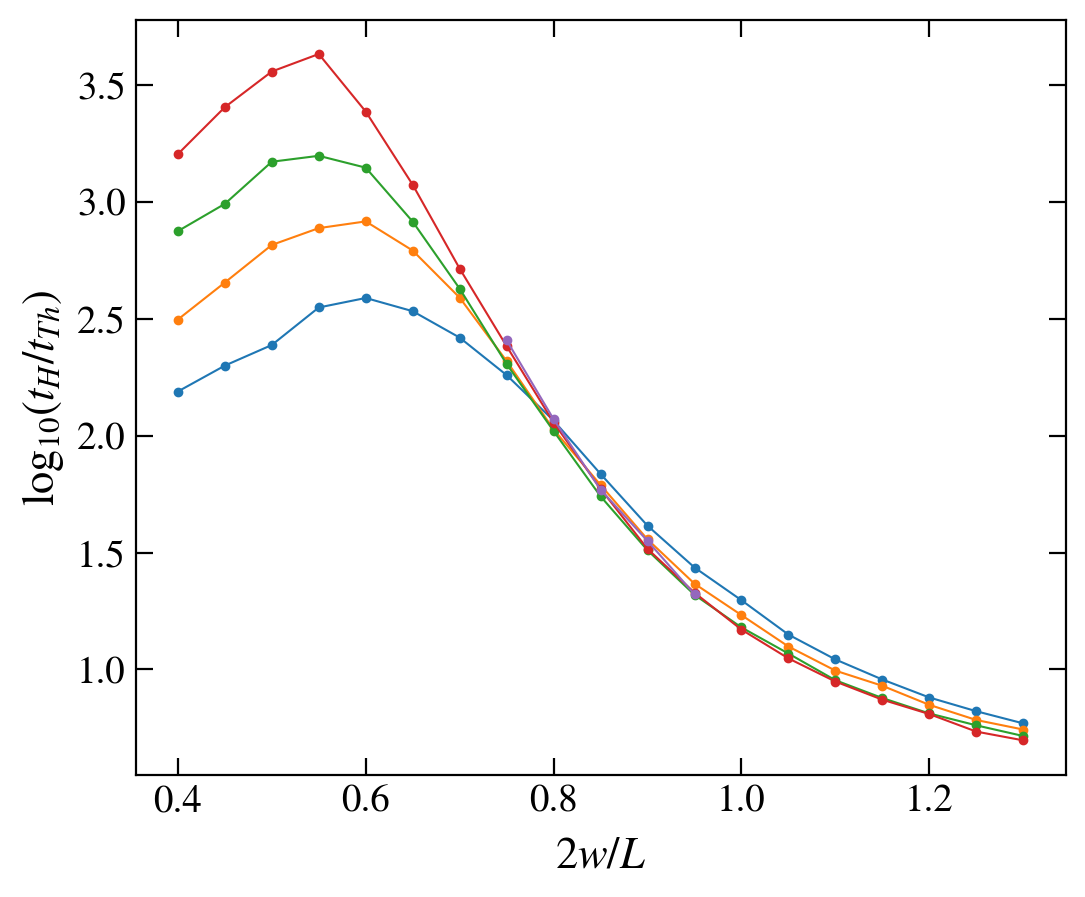

In [179]:
L_total=15
N=3

J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
gamma=1.0
ini_ave=0
L = L_total - N
scaled_disorder=1

sizes = np.arange(12, 17, 1) - N

folder = f'./thouless time_scaled disorder/'
os.makedirs(folder, exist_ok=True)

heisenberg_time = []
thouless_time = []
disorder = []
for L in sizes:
    t_Th    = np.zeros((w_vals.size))
    tH      = np.zeros((w_vals.size))
    tH_typ  = np.zeros((w_vals.size))
    name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            w_vals  = np.array(file.get('scaled disorder'))
            tH      = np.array(file.get('heisenberg time'))
            tH_typ  = np.array(file.get('typical heisenberg time'))
            t_Th    = np.array(file.get('thouless time'))
    else:
        print(name_out)
    
    thouless_time.append(tH_typ * t_Th)
    disorder.append(w_vals)
    heisenberg_time.append(tH_typ)

thouless_time = np.array(thouless_time)
heisenberg_time = np.array(heisenberg_time)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,5), dpi = 200)
# fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

for ii_L, L in enumerate(sizes):
    lab = r"$L+N=%g$"%(L+N)
    t_Th = np.log( heisenberg_time[ii_L] / thouless_time[ii_L] )
    axis.plot(disorder[ii_L], t_Th, marker='o', markersize=2.5, label=lab, lw=0.75)
    
# axis.plot(sizes, heisenberg_time[-1], color='k', ls='-.')
fig_help.set_plot_elements(axis, ylabel=r"$\log_{10}(t_H/t_{Th})$", xlabel=r"$2w/L$", font_size=14, set_legend=False, xscale='linear', yscale='linear')#), ylim=(3e1, 3e5))

# plt.savefig("plots/Fig2.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("plots/Fig2.png", bbox_inches = 'tight', pad_inches=0.02)

[0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
0.65 5 0.65
0.7 6 0.7000000000000001
0.75 7 0.75
0.8 8 0.8
0.85 9 0.8500000000000001
0.9 10 0.9


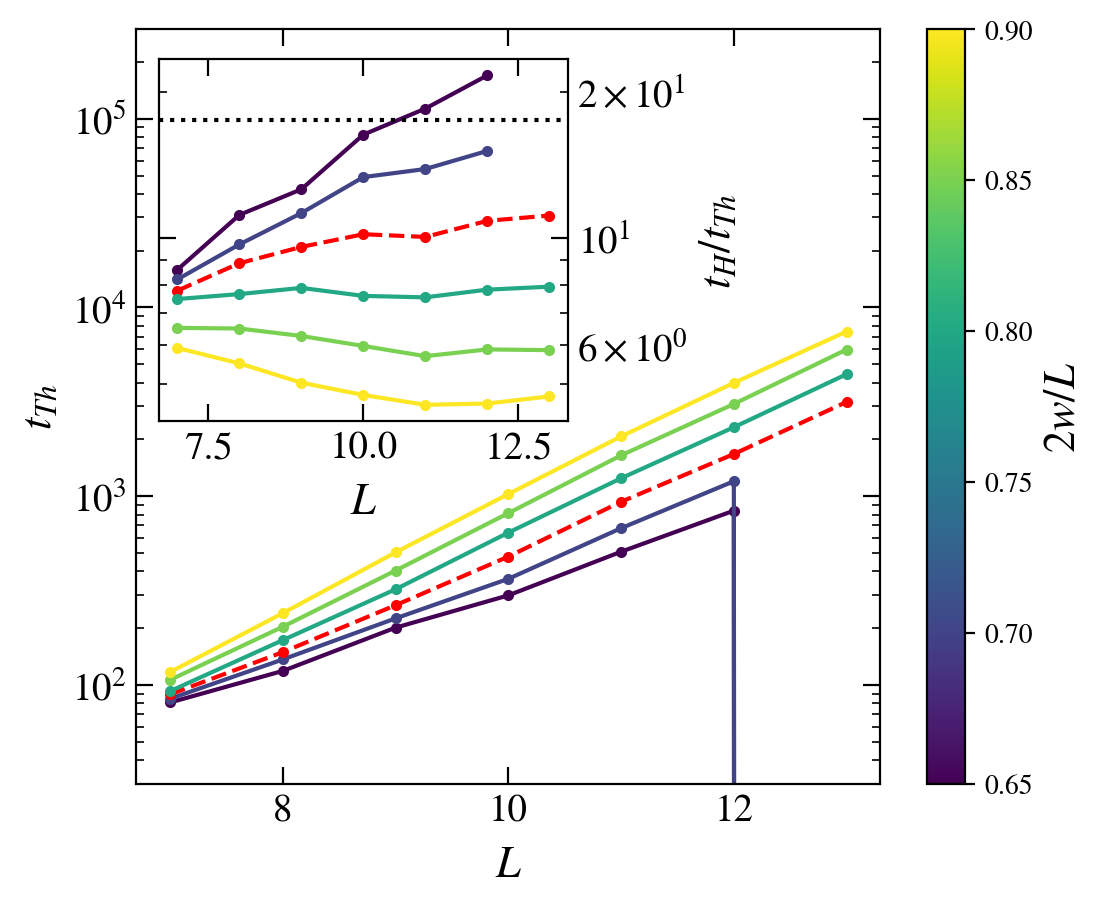

In [220]:
L_total=15
N=3

J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
gamma=1.0
ini_ave=0
L = L_total - N
scaled_disorder=1

sizes = np.arange(10, 17, 1) - N


w_vals_plot = [0.65, 0.7, 0.75, 0.76, 0.77, 0.78, 0.85, 0.9]
w_vals_plot = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

folder = f'./thouless time_scaled disorder/'
os.makedirs(folder, exist_ok=True)

heisenberg_time = []
thouless_time = []
disorder = []
for L in sizes:
    t_Th    = np.zeros((w_vals.size))
    tH      = np.zeros((w_vals.size))
    tH_typ  = np.zeros((w_vals.size))
    name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            w_vals  = np.array(file.get('scaled disorder'))
            tH      = np.array(file.get('heisenberg time'))
            tH_typ  = np.array(file.get('typical heisenberg time'))
            t_Th    = np.array(file.get('thouless time'))
    else:
        print(name_out)
    
    thouless_time.append(tH * t_Th)
    disorder.append(w_vals)
    heisenberg_time.append(tH)

thouless_time = np.transpose( np.array(thouless_time) )
heisenberg_time = np.transpose( np.array(heisenberg_time) )

norm = matplotlib.colors.Normalize(
        vmin=np.min(w_vals_plot),
        vmax=np.max(w_vals_plot))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,5), dpi = 200)
# fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

inset = axis.inset_axes([0.03, 0.48, 0.55, 0.48])
print(w_vals_plot)
exponent = []
for w in w_vals_plot:
    ii_w = (np.abs(w_vals - w)).argmin()
    print(w, ii_w, w_vals[ii_w])
    is_crit = np.round(w, 2)==0.75

    col = 'red' if is_crit else s_m.to_rgba(w)
    lin_s = '--' if is_crit else '-'
    lab = r"$2w/L=%g$"%w
    axis.plot(sizes, thouless_time[ii_w], marker='o', color=col, ls=lin_s, markersize=3, label=lab)
    inset.plot(sizes, heisenberg_time[ii_w] / thouless_time[ii_w], marker='o', color=col, ls=lin_s, markersize=3)

    pars, pconv = fit(exp_fit,
                        xdata = sizes,
                        ydata = thouless_time[ii_w])
    exponent.append(1./pars[0])

inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
inset.axhline(y=17.5, ls=':', c='black')

# axis.plot(sizes, heisenberg_time[-1], color='k', ls='-.')
fig_help.set_plot_elements(axis, ylabel=r"$t_{Th}$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='log', ylim=(3e1, 3e5))
fig_help.set_plot_elements(inset, ylabel=r"$t_H/t_{Th}$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='log')
# fig_help.set_legend(axis, loc = 'upper right', fontsize=12, anchor=(1., 1.), ncol=2)
cbar = fig.colorbar(s_m)
cbar.set_label(r"$2w/L$", fontsize=16)

# ax.plot(w_vals, exponent, marker='o', markersize=3)
# fig_help.set_plot_elements(ax, ylabel=r"$f$", xlabel=r"$W'=2w/L$", font_size=14, set_legend=False, xscale='linear', yscale='log')

for aa in [inset]:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

plt.savefig("plots/Fig2.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("plots/Fig2.png", bbox_inches = 'tight', pad_inches=0.02)

[0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05
 1.1  1.15 1.2  1.25 1.3 ]


Text(0.5, 1.0, "$\\frac{t_H}{t_{Th}}=Ae^{L/\\xi_0}\\qquad W'<W'_c=0.8\\qquad\\frac{t_H}{t_{Th}}=Ae^{-L/\\xi_1}$")

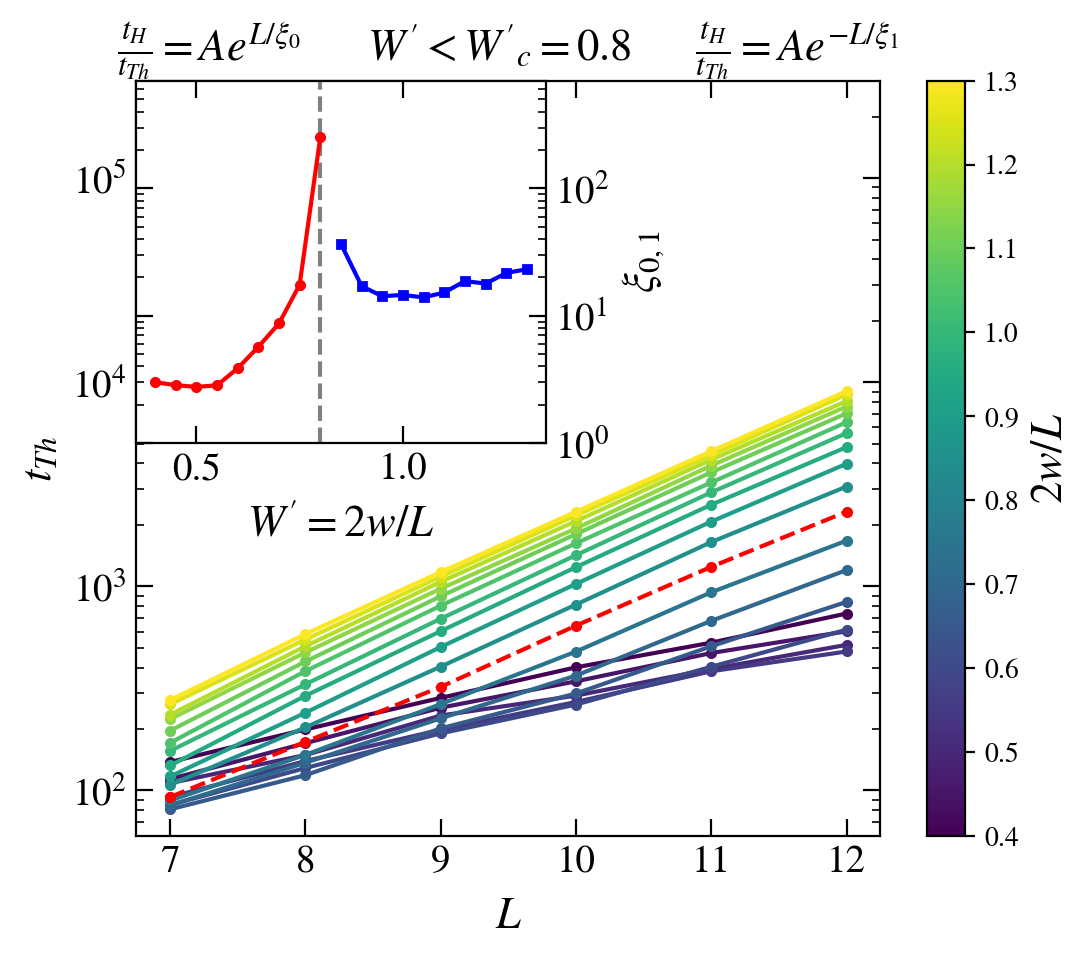

In [219]:
L_total=15
N=3

J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
gamma=1.0
ini_ave=0
L = L_total - N
scaled_disorder=1

sizes = np.arange(10, 16, 1) - N

w_crit = 0.8

w_vals_plot = [0.65, 0.7, 0.75, 0.76, 0.77, 0.78, 0.85, 0.9]
w_vals_plot = np.arange(0.4, 1.35, 0.05)

folder = f'./thouless time_scaled disorder/'
os.makedirs(folder, exist_ok=True)

heisenberg_time = []
thouless_time = []
disorder = []
for L in sizes:
    t_Th    = np.zeros((w_vals.size))
    tH      = np.zeros((w_vals.size))
    tH_typ  = np.zeros((w_vals.size))
    name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            w_vals  = np.array(file.get('scaled disorder'))
            tH      = np.array(file.get('heisenberg time'))
            tH_typ  = np.array(file.get('typical heisenberg time'))
            t_Th    = np.array(file.get('thouless time'))
    else:
        print(name_out)
    
    thouless_time.append(tH * t_Th)
    disorder.append(w_vals)
    heisenberg_time.append(tH)

thouless_time = np.transpose( np.array(thouless_time) )
heisenberg_time = np.transpose( np.array(heisenberg_time) )

norm = matplotlib.colors.Normalize(
        vmin=np.min(w_vals_plot),
        vmax=np.max(w_vals_plot))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,5), dpi = 200)
# fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

inset = axis.inset_axes([0.0, 0.52, 0.55, 0.48])
print(w_vals_plot)
xi0 = []
xi1 = []
for w in w_vals_plot:
    ii_w = (np.abs(w_vals - w)).argmin()
    # print(w, ii_w, w_vals[ii_w])
    is_crit = np.round(w, 2) == w_crit

    col = 'red' if is_crit else s_m.to_rgba(w)
    lin_s = '--' if is_crit else '-'
    lab = r"$2w/L=%g$"%w
    axis.plot(sizes, thouless_time[ii_w], marker='o', color=col, ls=lin_s, markersize=3, label=lab)

    th_ratio = heisenberg_time[ii_w] / thouless_time[ii_w]
    pars, pconv = fit(exp_fit2,
                        xdata = sizes,
                        ydata = th_ratio)
    xi0.append(pars[0])

    pars, pconv = fit(exp_fit,
                        xdata = sizes,
                        ydata = th_ratio)
    xi1.append(pars[0])

inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
# inset.axhline(y=17.5, ls=':', c='black')

# axis.plot(sizes, heisenberg_time[-1], color='k', ls='-.')
fig_help.set_plot_elements(axis, ylabel=r"$t_{Th}$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='log', ylim=(6e1, 3e5))
# fig_help.set_legend(axis, loc = 'upper right', fontsize=12, anchor=(1., 1.), ncol=2)
cbar = fig.colorbar(s_m)
cbar.set_label(r"$2w/L$", fontsize=16)


inset.axvline(x=w_crit, ls='--', color='gray')
xi0 = np.array(xi0)
xi1 = np.array(xi1)

inset.plot(w_vals[w_vals < w_crit+0.05], xi0[w_vals < w_crit+0.05], marker='o', markersize=3, color='red')
inset.plot(w_vals[w_vals > w_crit], xi1[w_vals > w_crit], marker='s', markersize=3, color='blue')
fig_help.set_plot_elements(inset, ylabel=r"$\xi_{0,1}$", xlabel=r"$W'=2w/L$", font_size=14, set_legend=False, xscale='linear', yscale='log', ylim=(1e0, 7e2))

# for aa in [inset]:
#     ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#     ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#     ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#     ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

axis.set_title(r"$\frac{t_H}{t_{Th}}=Ae^{L/\xi_0}\qquad W'<W'_c=0.8\qquad\frac{t_H}{t_{Th}}=Ae^{-L/\xi_1}$", fontsize=16)
# plt.savefig("plots/Fig2.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("plots/Fig2.png", bbox_inches = 'tight', pad_inches=0.02)

## MATRIX ELEMENTS

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5 ]
7 4000.0
8 4000.0
9 3497.0
10 807.0
11 263.0
12 110.0
7 4000.0
8 4000.0
9 3497.0
10 807.0
11 263.0
12 110.0
7 4000.0
8 4000.0
9 3497.0
10 807.0
11 263.0
12 110.0
7 4000.0
8 4000.0
9 3497.0
10 807.0
11 263.0
12 110.0
7 4000.0
8 4000.0
9 3497.0
10 807.0
11 263.0
12 110.0


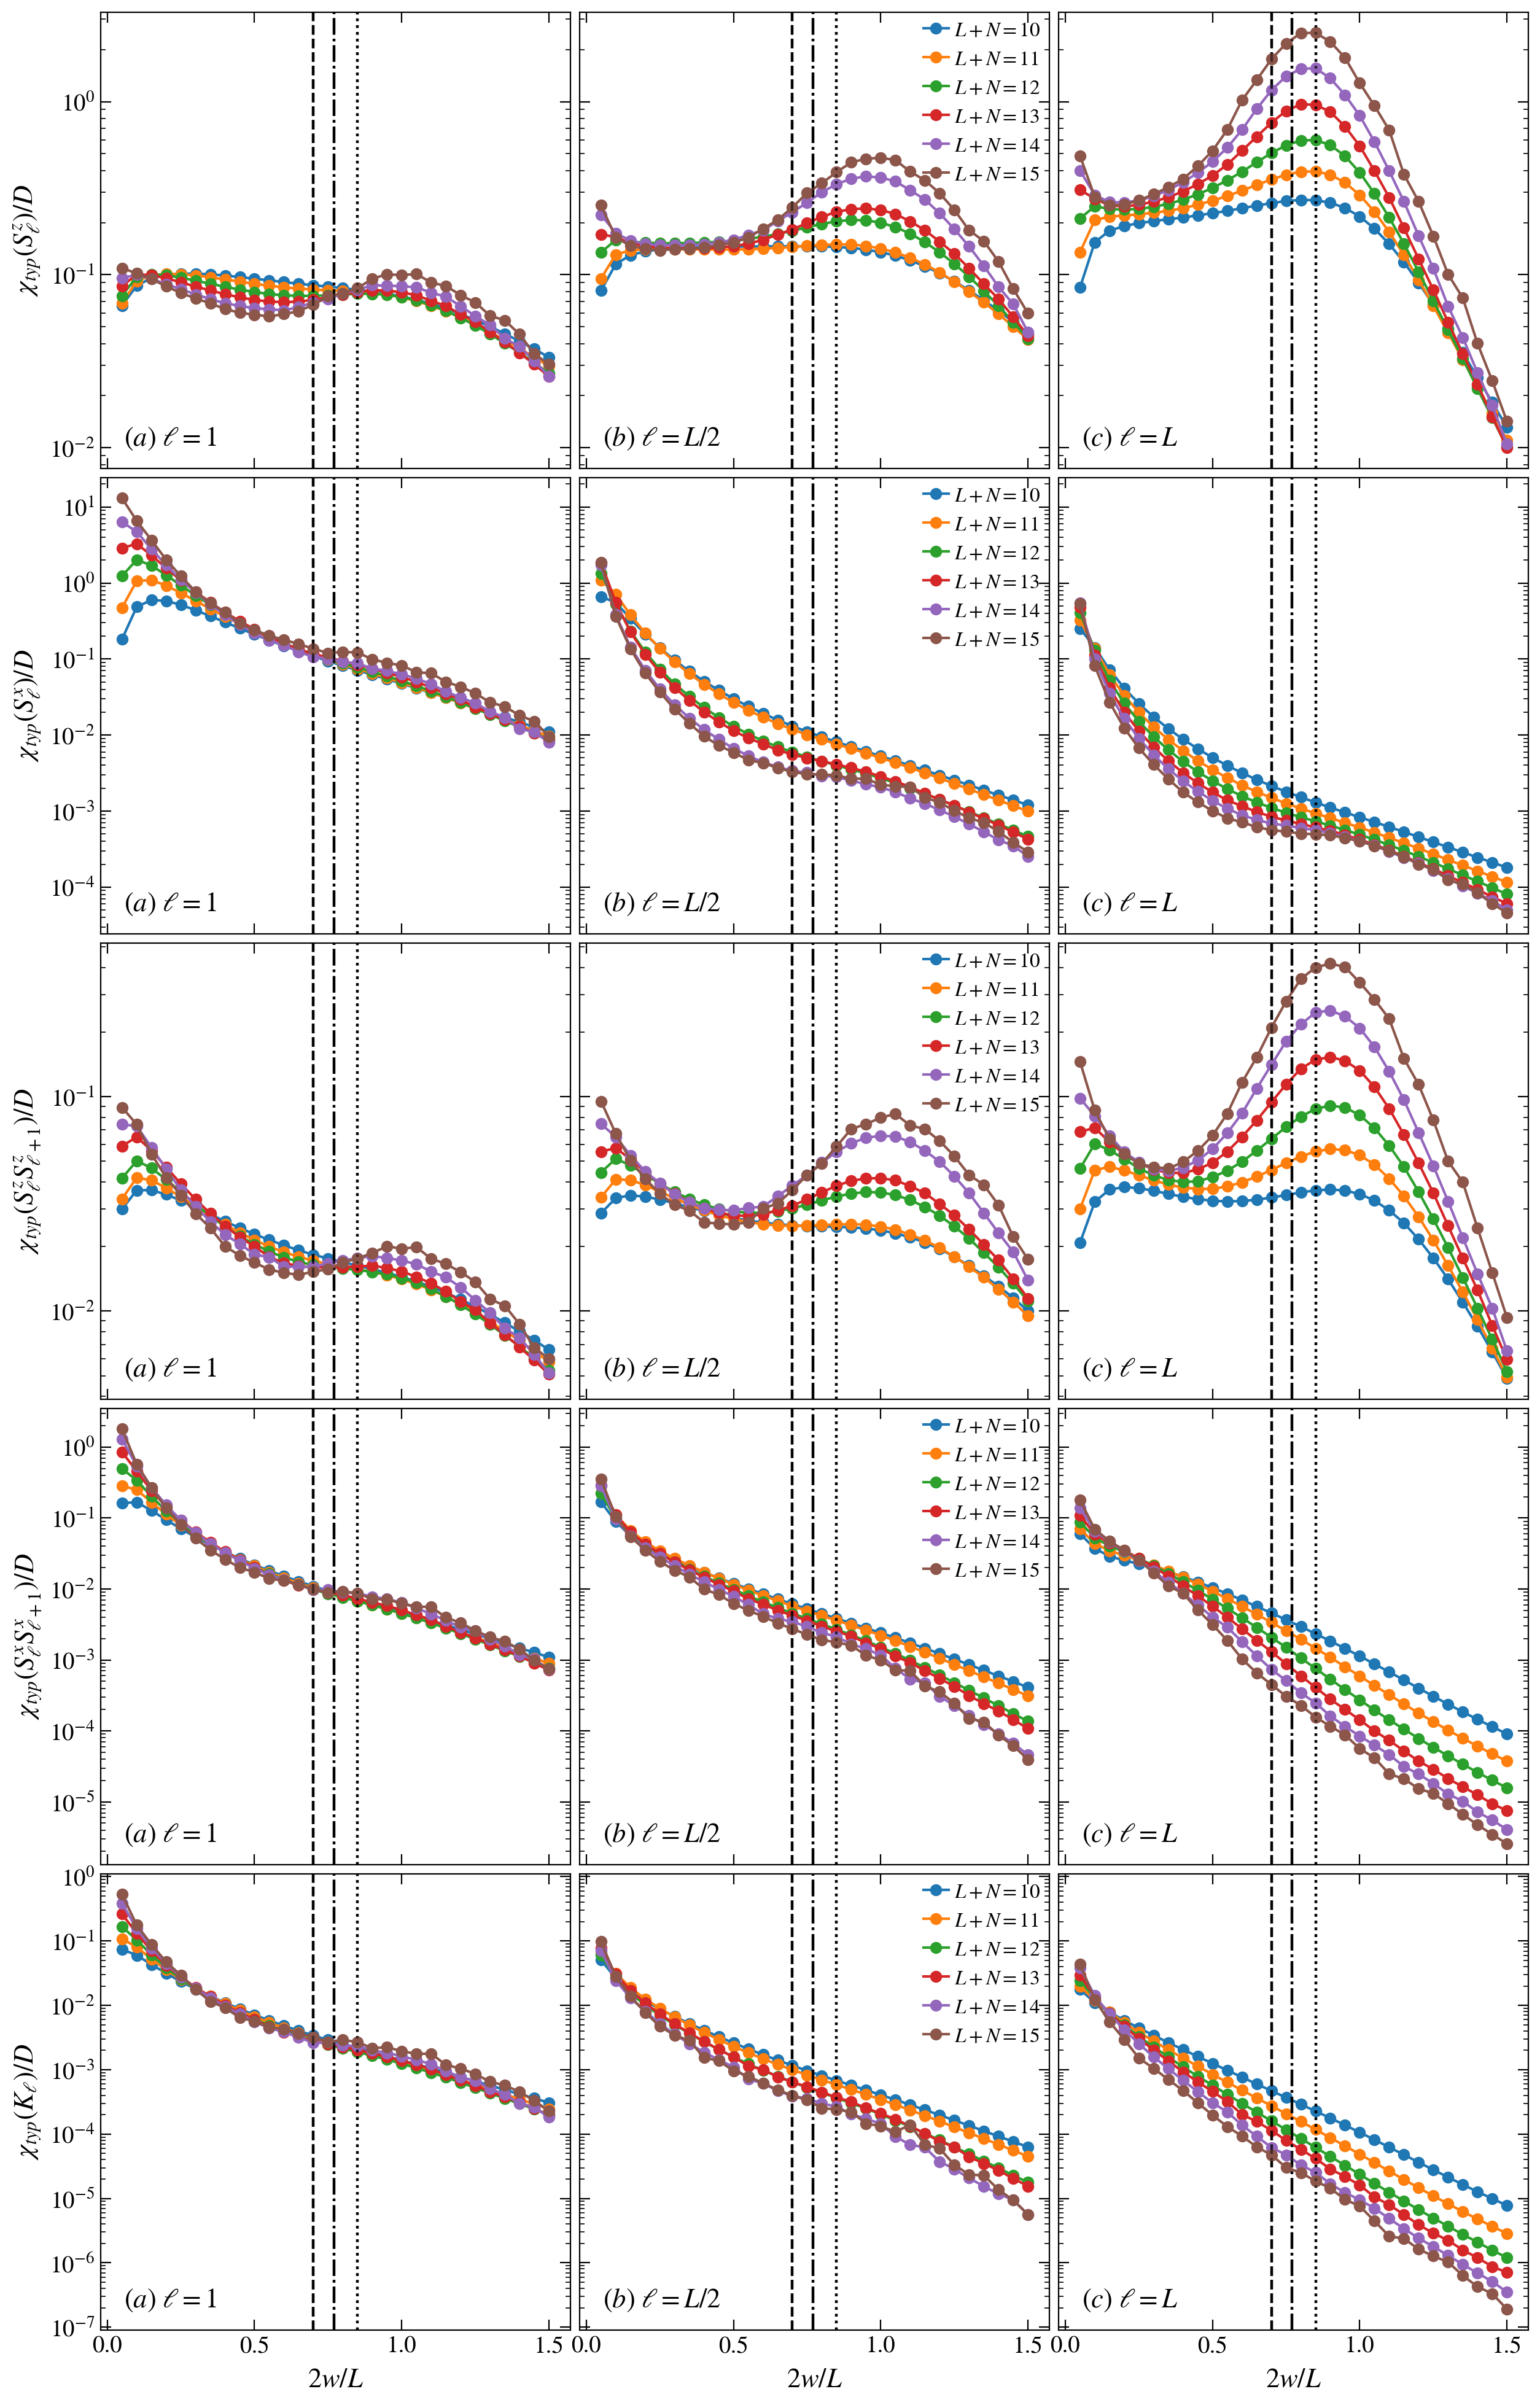

In [182]:
L_total=15

J=1
alfa=1.0
h=0.0
w=0.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

scaled_disorder = 1

# w_vals = np.unique( np.round( np.array( [ *np.linspace(0.4, 1.3, 19), *np.linspace(0.7, 0.82, 13)] ), 3) )
w_vals = np.linspace(0.05, 1.5, 30)
print(w_vals)

sizes = np.arange(10, 16, 1)

xlab = r"$2w / L$"

fig, axes = plt.subplots( nrows=5, ncols=3, figsize=(15,25), dpi = 200, sharex=True, sharey='row')
ylab_in = ['S^z_\ell', 'S^x_\ell', 'S^z_\ell S^z_{\ell+1}', 'S^x_\ell S^x_{\ell+1}', 'K_\ell']
for iii, operator_name in enumerate(['Sz', 'Sx', 'SzSz', 'SxSx', 'kin']):
    p=0
    axis = [axes[iii][0], axes[iii][1], axes[iii][2]]
    if iii > 1: p=1
    for L_total in sizes:
        dim = 2**L_total
        L = L_total - N
        sites    = np.zeros((L_total));    sites.fill(np.nan)
        agp      = np.zeros((w_vals.size, L_total - p));    agp.fill(np.nan)
        typ_susc = np.zeros((w_vals.size, L_total - p));    typ_susc.fill(np.nan)
        _var     = np.zeros((w_vals.size, L_total));        _var.fill(np.nan)
        wH       = np.zeros((w_vals.size));                 wH.fill(np.nan)
        realisations = np.zeros((w_vals.size));             realisations.fill(np.nan)
        # susc = np.zeros((L_total));    sites.fill(np.nan)
        _exist = 0
        _first_wH = -1
        _last_wH = -1
        for ii, w in enumerate(w_vals):
            name = base_dir + 'MatrixElements/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
            if exists(name):
                with h5py.File(name, "r") as file:
                    sites        = np.array(file.get('sites')).astype(int)
                    agp[ii]      = np.array(file.get('AGP/' + operator_name))
                    # print('AGP/' + name)
                    typ_susc[ii] = np.array(file.get('TYP_SUSC/' + operator_name))
                    mat_elem = np.transpose(np.array(file.get('DIAG_MAT/' + operator_name)))
                    _var[ii]     = np.array([np.var(aa) for aa in mat_elem])
                    realisations[ii] = np.array(file.get('realisations'))
                    _exist = 1
            else:
                print(name)
            name = base_dir + 'SpectralFormFactor/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
            
            if exists(name):
                with h5py.File(name, "r") as file:
                    _last_wH = ii
                    if _first_wH < 0: _first_wH = ii
                    wH[ii] = 1./np.array(file.get('tH'))[0]
        
        if _exist:                
            print(L, min(realisations) )

            agp = np.transpose(agp)
            _var = np.transpose(_var)
            typ_susc = np.transpose(typ_susc)
            
            _sites_ = [N, (N + L)//2, L_total - 1- p]
            for ii, ell in enumerate(_sites_):
                idx = list(sites).index(ell)
                # axis[ii].plot(w_vals, agp[idx] / dim, marker='o', label=r"$L+N=%d$"%L_total)
                axis[ii].plot(w_vals, typ_susc[idx] / dim, marker='o', label=r"$L+N=%d$"%L_total)
                # print(_var(idx))
                # axis[ii].plot(w_vals, np.sqrt(_var[idx] * dim), marker='o', label=r"$L+N=%d$"%L_total)
        
        for ax in axis:
            ax.axvline(x=0.7, ls='--', c='k', alpha=0.5)
            ax.axvline(x=0.77, ls='-.', c='k', alpha=0.5)
            ax.axvline(x=0.85, ls=':', c='k', alpha=0.5)
    # ylab = r"$D(\omega_H)^2\chi(S^z_\ell)/L_{tot}$"
    ylab = r"$\chi_{typ}(%s)/D$"%ylab_in[iii]
    # ylab = r"$\sigma(%s)D$"%ylab_in[iii]
    # ylab = r"$||%s)||^2/D$"%ylab_in[iii]
    fig_help.set_plot_elements(axis[0], ylabel=ylab, xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='linear')
    fig_help.set_plot_elements(axis[1], ylabel="",   xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='linear')
    fig_help.set_plot_elements(axis[2], ylabel="",   xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='linear')
    fig_help.set_legend(axis[1], loc = 'upper right', fontsize=12)#, anchor=(-0.02, 0.35))

    axis[0].annotate(r"$(a)\ \ell=1$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
    axis[1].annotate(r"$(b)\ \ell=L/2$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
    axis[2].annotate(r"$(c)\ \ell=L$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
    fig.subplots_adjust(wspace = 0.02, hspace=0.02)

# plt.savefig("plots/Fig_mat_elem.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("plots/Fig_mat_elem.png", bbox_inches = 'tight', pad_inches=0.02)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5 ]


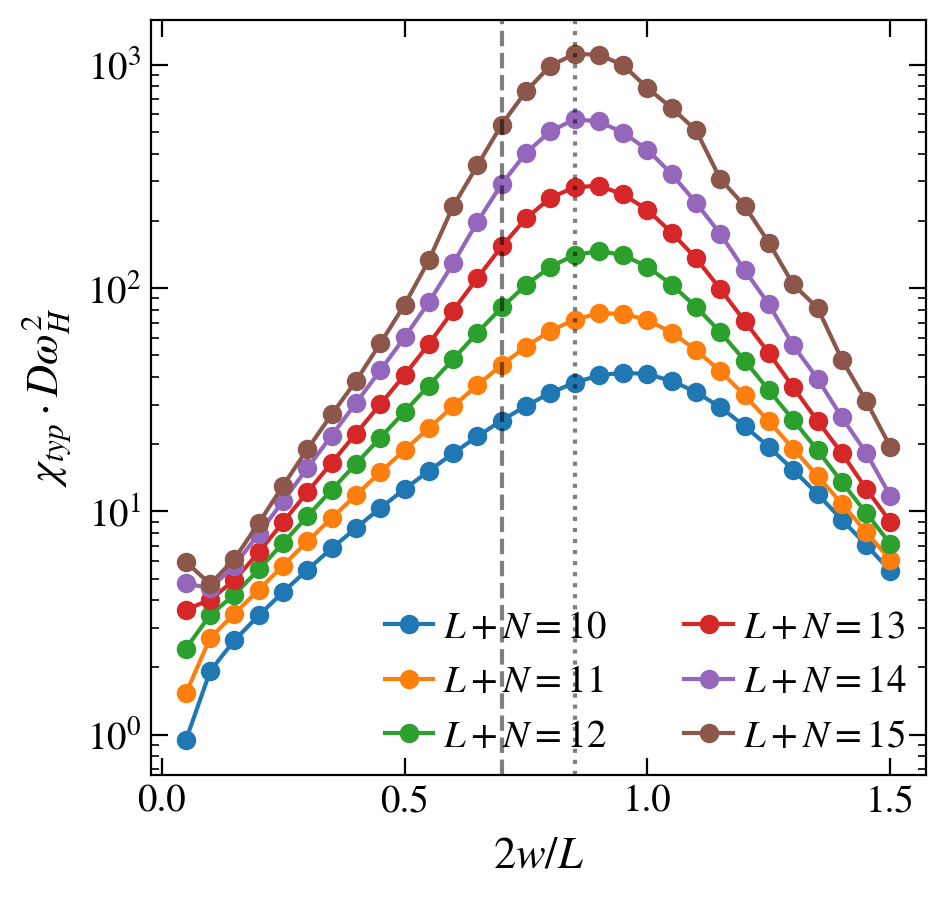

In [51]:
L_total=15

J=1
alfa=1.0
h=0.0
w=0.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

scaled_disorder = 1

# w_vals = np.unique( np.round( np.array( [ *np.linspace(0.4, 1.3, 19), *np.linspace(0.7, 0.82, 13)] ), 3) )
w_vals = np.linspace(0.05, 1.5, 30)
print(w_vals)

sizes = np.arange(10, 16, 1)

xlab = r"$2w / L$"

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharex=True, sharey='row')
ylab_in = ['S^z_\ell']
for iii, operator_name in enumerate(['Sz']):
    p=0
    for L_total in sizes:
        dim = 2**L_total
        L = L_total - N
        sites    = np.zeros((L_total));    sites.fill(np.nan)
        agp      = np.zeros((w_vals.size, L_total - p));    agp.fill(np.nan)
        typ_susc = np.zeros((w_vals.size, L_total - p));    typ_susc.fill(np.nan)
        _var     = np.zeros((w_vals.size, L_total));        _var.fill(np.nan)
        wH       = np.zeros((w_vals.size));                 wH.fill(np.nan)
        realisations = np.zeros((w_vals.size));             realisations.fill(np.nan)
        # susc = np.zeros((L_total));    sites.fill(np.nan)
        _exist = 0
        _first_wH = -1
        _last_wH = -1
        for ii, w in enumerate(w_vals):
            name = base_dir + 'MatrixElements/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
            if exists(name):
                with h5py.File(name, "r") as file:
                    sites        = np.array(file.get('sites')).astype(int)
                    agp[ii]      = np.array(file.get('AGP/' + operator_name))
                    # print('AGP/' + name)
                    typ_susc[ii] = np.array(file.get('TYP_SUSC/' + operator_name))
                    mat_elem = np.transpose(np.array(file.get('DIAG_MAT/' + operator_name)))
                    _var[ii]     = np.array([np.var(aa) for aa in mat_elem])
                    # realisations[ii] = np.array(file.get('realisations'))
                    _exist = 1
            else:
                print(name)
            name = base_dir + 'SpectralFormFactor/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
            
            if exists(name):
                with h5py.File(name, "r") as file:
                    _last_wH = ii
                    if _first_wH < 0: _first_wH = ii
                    wH[ii] = 1./np.array(file.get('tH'))[0]
        
        wH = np.sqrt(1 + J**2 / 4 + L_total / 4 * ((w_vals * L_total / 2)**2 / 3)) / (0.3413 * dim)
        if _exist:                
            # print(L, min(realisations) , wH)

            agp = np.transpose(agp)
            _var = np.transpose(_var)
            typ_susc = np.transpose(typ_susc)
            
            p2 = 0
            _sites_ = [L_total - 1 - p2]
            # _sites_ = [L_total//2]
            for ii, ell in enumerate(_sites_):
                idx = list(sites).index(ell)
                # axis.plot(w_vals, agp[idx] / dim, marker='o', label=r"$L+N=%d$"%L_total)
                axis.plot(w_vals, typ_susc[idx] * dim * wH**2, marker='o', label=r"$L+N=%d$"%L_total)
                # print(_var(idx))
                # axis[ii].plot(w_vals, np.sqrt(_var[idx] * dim), marker='o', label=r"$L+N=%d$"%L_total)

    axis.axvline(x=0.7, ls='--', c='k', alpha=0.5)
    # axis.axvline(x=0.77, ls='-.', c='k', alpha=0.5)
    axis.axvline(x=0.85, ls=':', c='k', alpha=0.5)
    # ylab = r"$D(\omega_H)^2\chi(S^z_\ell)/L_{tot}$"
    # ylab = r"$\chi_{typ}(%s)/D$"%ylab_in[iii]
    ylab = r"$\chi_{typ}\cdot D\omega_H^2$"
    # ylab = r"$\sigma(%s)D$"%ylab_in[iii]
    # ylab = r"$||S^z_\ell)||^2/D$"
    fig_help.set_plot_elements(axis, ylabel=ylab, xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='linear')
    # fig_help.set_plot_elements(axis[1], ylabel="",   xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='linear')
    # fig_help.set_plot_elements(axis[2], ylabel="",   xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='linear')
    fig_help.set_legend(axis, loc = 'lower right', fontsize=14, ncol=2)#, anchor=(-0.02, 0.35))

    # axis[0].annotate(r"$(a)\ \ell=1$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
    # axis[1].annotate(r"$(b)\ \ell=L/2$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
    # axis[2].annotate(r"$(c)\ \ell=L$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
    fig.subplots_adjust(wspace = 0.02, hspace=0.02)

plt.savefig("plots/Fig4.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("plots/Fig4.png", bbox_inches = 'tight', pad_inches=0.02)

12 [157. 184. 155. 137. 156. 148. 165.]
12 [157. 184. 155. 137. 156. 148. 165.]
12 [157. 184. 155. 137. 156. 148. 165.]
12 [157. 184. 155. 137. 156. 148. 165.]
12 [157. 184. 155. 137. 156. 148. 165.]


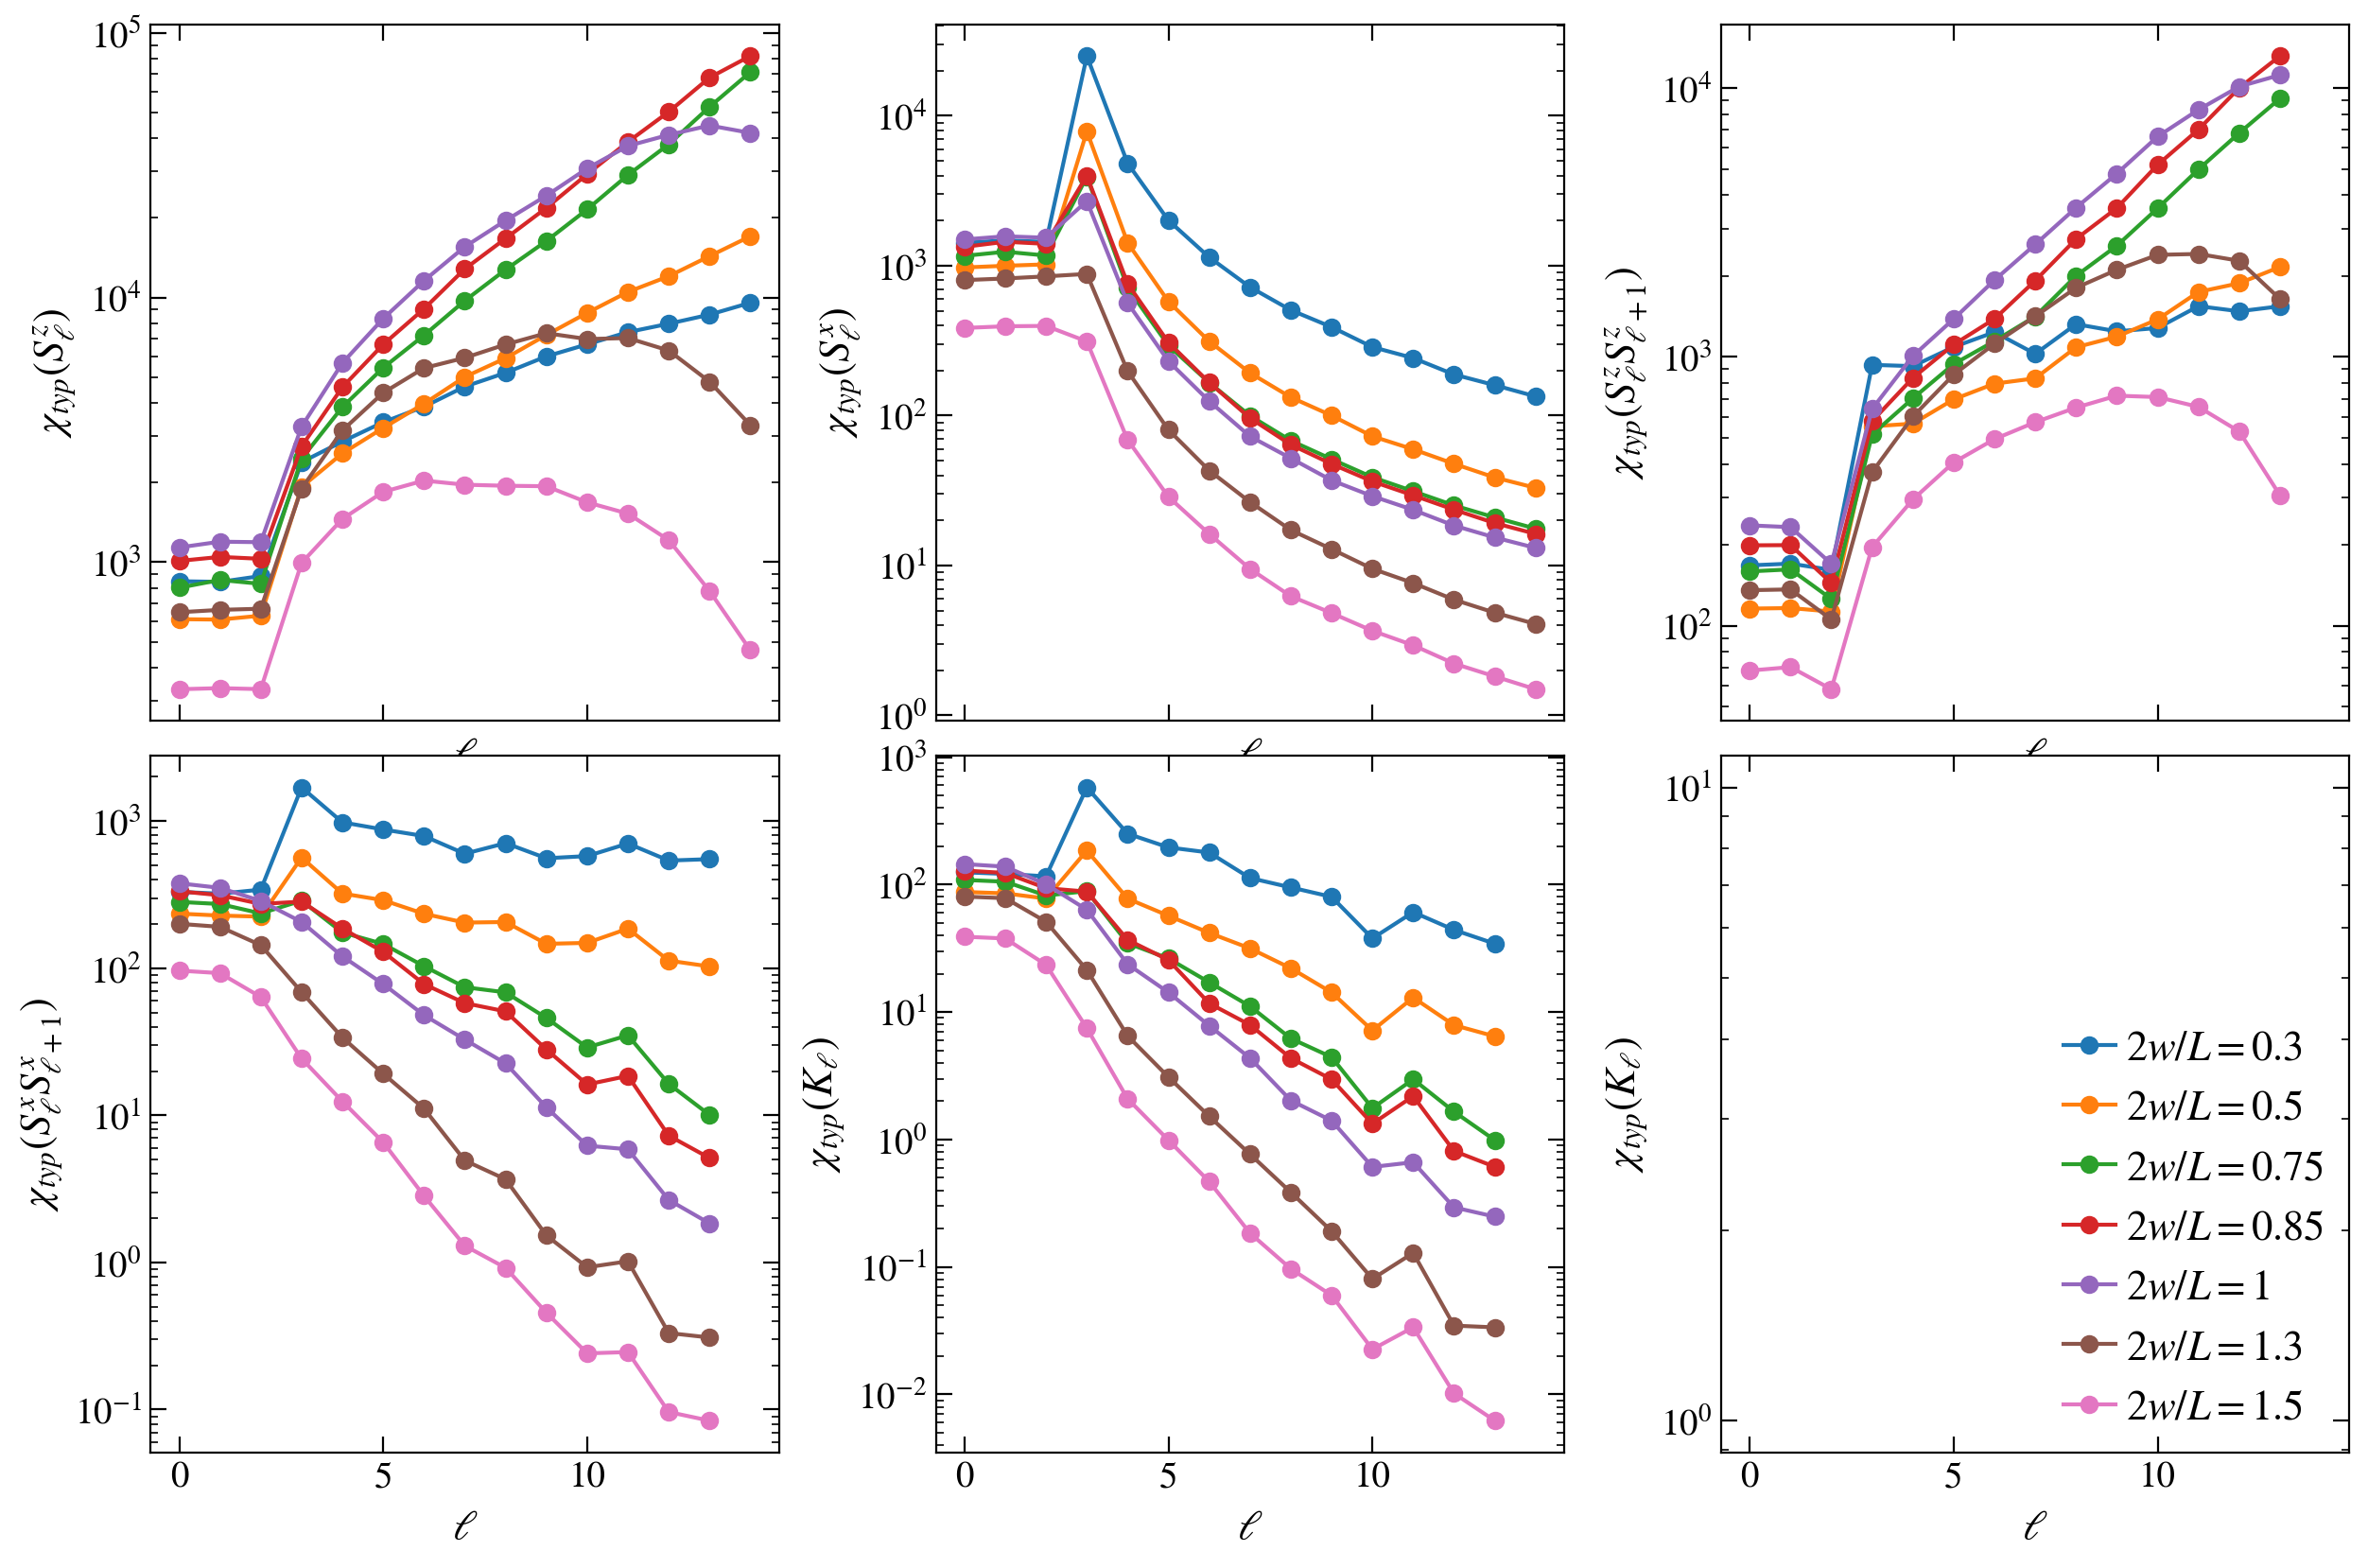

In [184]:
L_total=15

J=1
alfa=1.0
h=0.0
w=0.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

scaled_disorder = 1

# w_vals = np.unique( np.round( np.array( [ *np.linspace(0.4, 1.3, 19), *np.linspace(0.7, 0.82, 13)] ), 3) )

w_vals = np.array([0.3, 0.5, 0.75, 0.85, 1.0, 1.3, 1.5])

sizes = np.arange(10, 16, 1)

xlab = r"$\ell$"

fig, axes = plt.subplots( nrows=2, ncols=3, figsize=(15,10), dpi = 200, sharex=True)
axes = axes.flatten()
dim = 2**L_total
L = L_total - N
ylab_in = ['S^z_\ell', 'S^x_\ell', 'S^z_\ell S^z_{\ell+1}', 'S^x_\ell S^x_{\ell+1}', 'K_\ell']
for iii, operator_name in enumerate(['Sz', 'Sx', 'SzSz', 'SxSx', 'kin']):
    axis = axes[iii]
    p=0
    if iii > 1: p=1
    sites    = np.zeros((L_total));    sites.fill(np.nan)
    agp      = np.zeros((w_vals.size, L_total - p));    agp.fill(np.nan)
    typ_susc = np.zeros((w_vals.size, L_total - p));    typ_susc.fill(np.nan)
    wH       = np.zeros((w_vals.size));             wH.fill(np.nan)
    realisations = np.zeros((w_vals.size));             realisations.fill(np.nan)
    # susc = np.zeros((L_total));    sites.fill(np.nan)
    for ii, w in enumerate(w_vals):
        name = base_dir + 'MatrixElements/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
        
        if exists(name):
            with h5py.File(name, "r") as file:
                    sites        = np.array(file.get('sites')).astype(int)
                    agp[ii]      = np.array(file.get('AGP/' + operator_name))
                        # print('AGP/' + name)
                    typ_susc[ii] = np.array(file.get('TYP_SUSC/' + operator_name))
                    realisations[ii] = np.array(file.get('realisations'))
        else:
            print(name)
        name = base_dir + 'SpectralFormFactor/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
        
        if exists(name):
            with h5py.File(name, "r") as file:
                    wH[ii] = 1./np.array(file.get('tH'))[0]
    print(L, realisations)

    # agp = np.transpose(agp)
    # typ_susc = np.transpose(typ_susc)

    for ii, w in enumerate(w_vals):
        # yy = agp[ii]
        yy = typ_susc[ii]
        if iii > 1: axis.plot(sites[:-1], yy, marker='o')
        else:       axis.plot(sites,      yy, marker='o')
        # axis.plot(sites, typ_susc[ii], marker='o', label=r"$w=%g$"%w)

    # ylab = r"$\chi(S^z_\ell)$"
    # ylab = r"$||S^z_\ell)||/D$"
    ylab = r"$||%s||^2$"%ylab_in[iii]
    ylab = r"$\chi_{typ}(%s)$"%ylab_in[iii]
    fig_help.set_plot_elements(axis, ylabel=ylab, xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='linear')

axis = axes[-1]
for ii, w in enumerate(w_vals):
     axis.plot(np.nan, np.nan, marker='o', label=r"$2w/L=%g$"%w)

fig_help.set_plot_elements(axis, ylabel=ylab, xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='linear')
fig_help.set_legend(axis, loc = 'lower right', fontsize=16)#, anchor=(-0.02, 0.35))
# axis[0].annotate(r"$(a)\ \ell=1$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
# axis[1].annotate(r"$(b)\ \ell=L/2$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
# axis[2].annotate(r"$(c)\ \ell=L$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
fig.subplots_adjust(wspace = 0.25, hspace=0.05)

[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85
 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3 ]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


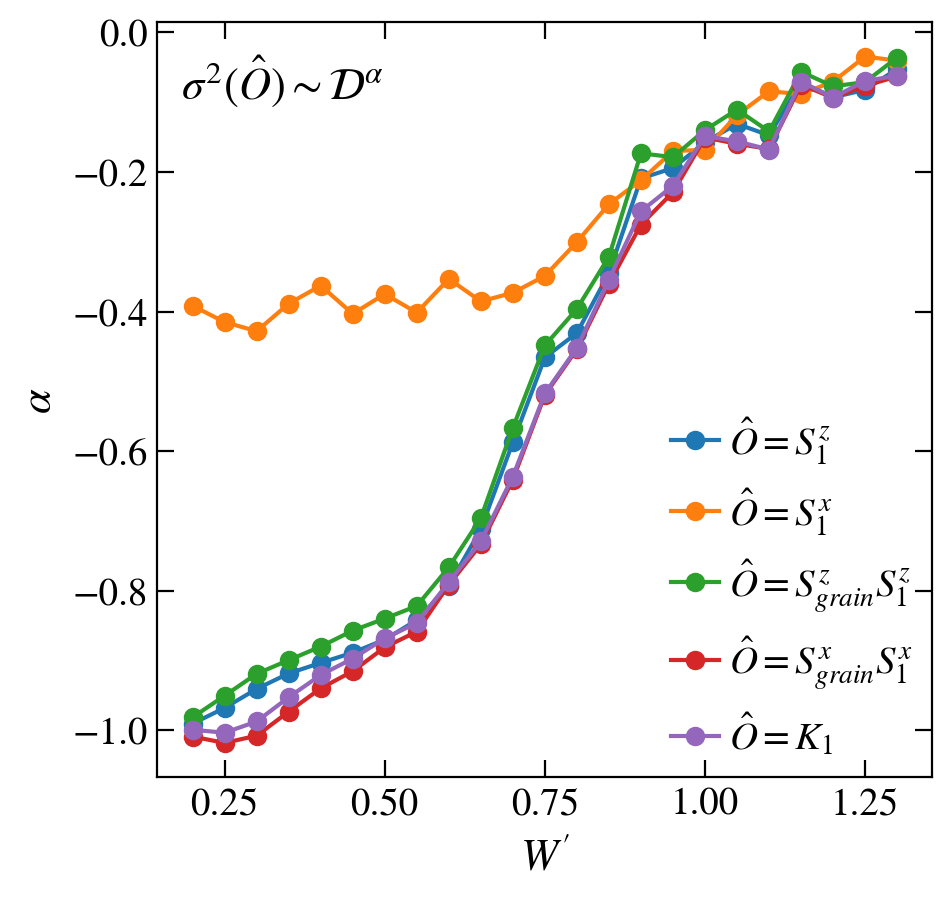

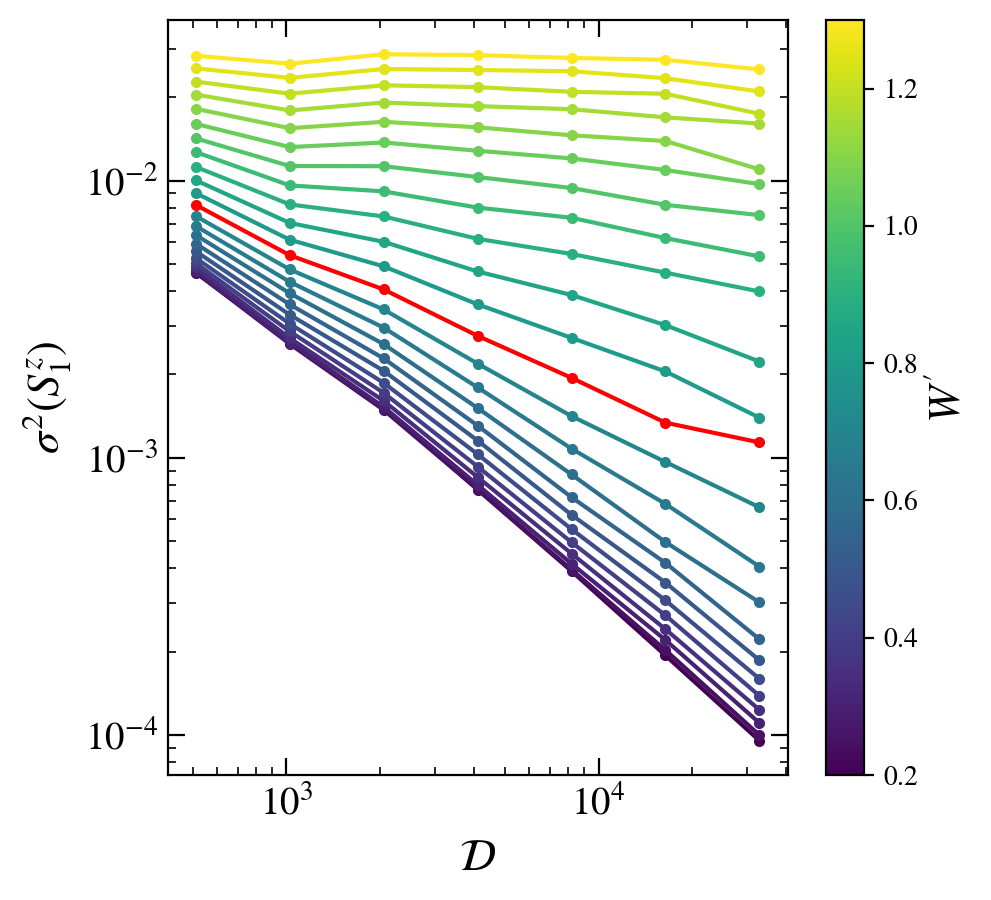

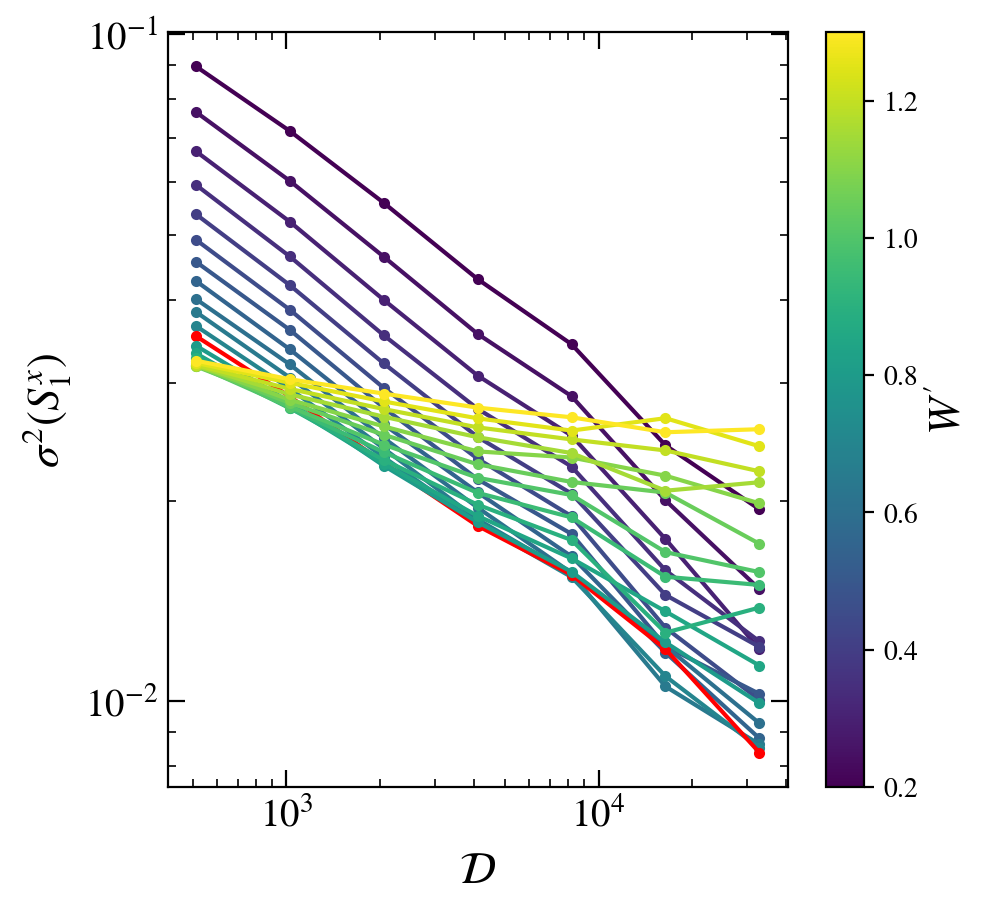

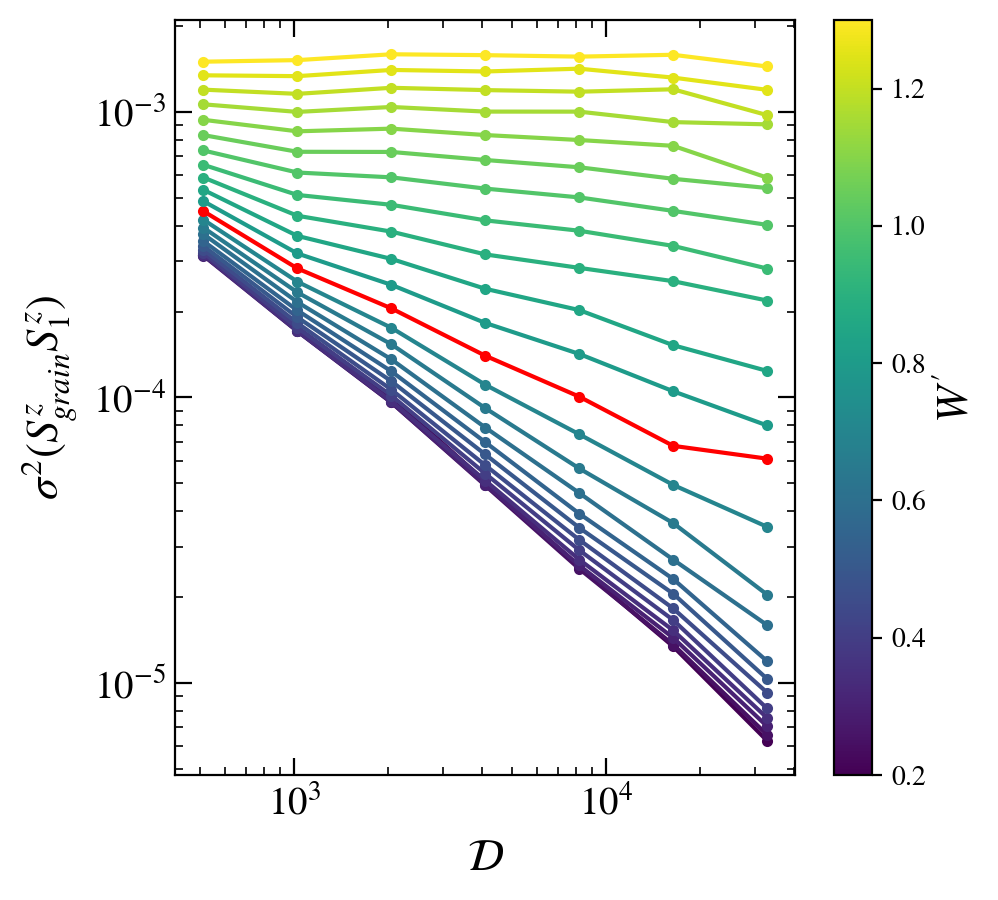

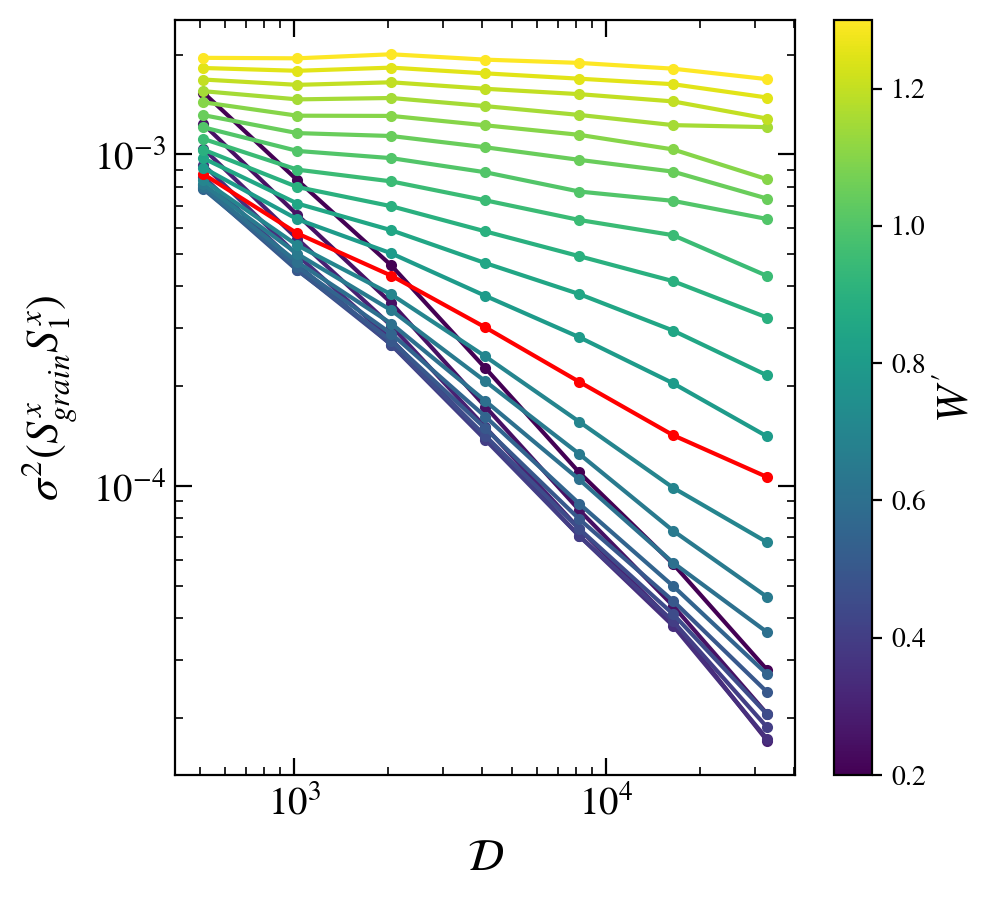

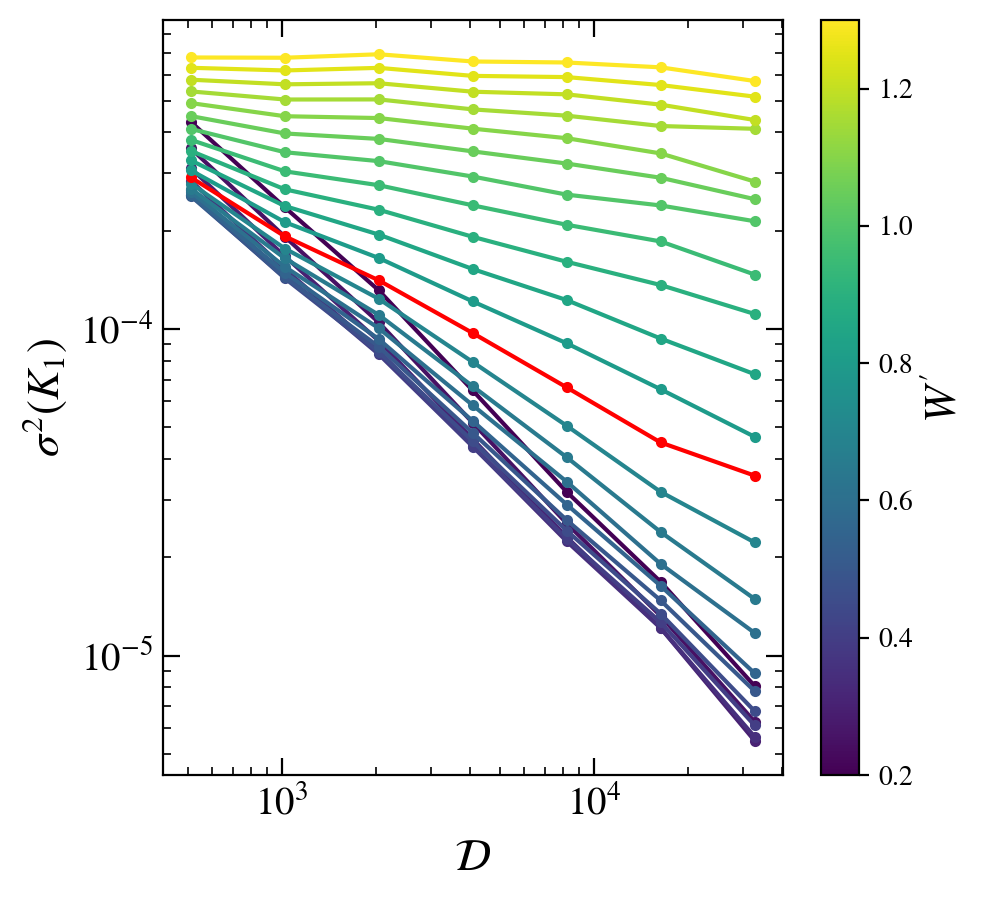

In [8]:
L_total=15

J=1
alfa=1.0
h=0.0
w=0.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

scaled_disorder = 1
w_crit=0.75

# w_vals = np.unique( np.round( np.array( [ *np.linspace(0.4, 1.3, 19), *np.linspace(0.7, 0.82, 13)] ), 3) )
w_vals = np.linspace(0.2, 1.3, 23)
print(w_vals)

sizes = np.arange(9, 16, 1)

xlab = r"$\mathcal{D}$"
norm = matplotlib.colors.Normalize(
        vmin=np.min(w_vals),
        vmax=np.max(w_vals))

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharex=True, sharey='row')
ylab_in = ['S^z_1', 'S^x_1', 'S^z_{grain} S^z_{1}', 'S^x_{grain} S^x_{1}', 'K_1']
for iii, operator_name in enumerate(['Sz', 'Sx', 'SzSz', 'SxSx', 'kin']):
    p = 0 if iii < 2 else 1
    fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharex=True, sharey='row')

    exponent = np.zeros(w_vals.shape)
    for ii_w, w in enumerate(w_vals):
        agp      = np.zeros((sizes.size));    agp.fill(np.nan)
        typ_susc = np.zeros((sizes.size));    typ_susc.fill(np.nan)
        _var     = np.zeros((sizes.size));    _var.fill(np.nan)
        # realisations = np.zeros((sizes.size)); realisations.fill(np.nan)
        
        for ii, L_total in enumerate(sizes):
            dim = 2**L_total
            L = L_total - N
            name = base_dir + 'MatrixElements/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
            if exists(name):
                with h5py.File(name, "r") as file:
                    agp[ii]      = np.array(file.get('AGP/' + operator_name))[-1]
                    typ_susc[ii] = np.array(file.get('TYP_SUSC/' + operator_name))[-1]
                    mat_elem = np.array(file.get('DIAG_MAT/' + operator_name))
                    _var[ii]     = mat_elem[1, N-p]
                    nuus = np.array(file.get('DIAG_MAT/nuss'))
                    # print(nuus.shape, mat_elem.shape)
                    # print(nuus)
                    
            else:
                print(name)
            # name = base_dir + 'SpectralFormFactor/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5', scaled_disorder=scaled_disorder)
            
            # if exists(name):
            #     with h5py.File(name, "r") as file:
            #         _last_wH = ii
            #         if _first_wH < 0: _first_wH = ii
            #         wH[ii] = 1./np.array(file.get('tH'))[0]
        
        col = 'red' if w==w_crit else s_m.to_rgba(w)

        dims = 2**sizes
        # axis.plot(dims, typ_susc / dims, marker='o', color=col)
        axis.plot(dims, (_var), marker='o', markersize=3, color=col)

        pars, pconv = fit(power_law,
                    xdata = dims[-4:],
                    ydata = _var[-4:])
        # print(operator_name, np.round(w,2), pars[0])
        exponent[ii_w] = pars[0]


    ax.plot(w_vals, exponent, marker='o', label=r"$\hat{O}=%s$"%ylab_in[iii])
    # ylab = r"$D(\omega_H)^2\chi(S^z_\ell)/L_{tot}$"
    # ylab = r"$\chi_{typ}(%s)/D$"%ylab_in[iii]
    # ylab = r"$\chi_{typ}/D$"
    ylab = r"$\sigma^2(%s)$"%ylab_in[iii]
    fig_help.set_plot_elements(axis, ylabel=ylab, xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='log')
    fig_help.set_legend(axis, loc = 'lower left', fontsize=14, ncol=2)#, anchor=(-0.02, 0.35))

    # axis.plot(dims, 1e-2 / (dims/1e3)**0.5, ls='--', c='k')
    # axis.plot(dims, 1e-2 / (dims/1e3)**0.75, ls=':', c='k')
    cbar = fig.colorbar(s_m)#, ax=a, location='top', fraction = 0.6)
    cbar.set_label(r"$W'$", fontsize=16)

    # axis[0].annotate(r"$(a)\ \ell=1$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
    # axis[1].annotate(r"$(b)\ \ell=L/2$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
    # axis[2].annotate(r"$(c)\ \ell=L$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
    fig.subplots_adjust(wspace = 0.02, hspace=0.02)
ax.annotate(r"$\sigma^2(\hat{O})\sim\mathcal{D}^{\alpha}$", fontsize=16, xy=(0.03, 0.9), xycoords='axes fraction')
fig_help.set_plot_elements(ax, xlabel=r"$W'$", ylabel=r"$\alpha$", font_size=14, set_legend=False, yscale='linear', xscale='linear')
fig_help.set_legend(ax, loc = 'lower right', fontsize=14, ncol=1)#, anchor=(-0.02, 0.35))
# plt.savefig("plots/Fig4.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("plots/Fig4.png", bbox_inches = 'tight', pad_inches=0.02)

## SURVIVAL PROBABILITY

[0.75 0.8  0.85 0.9  0.95]
0.65 [1.90553960e-04 1.54926982e+00 6.72391804e-01] [0.01484149 0.00943709 0.00595485 0.00383684 0.00242748 0.00163158] [0.01484691 0.00938691 0.00596095 0.00381128 0.00246244 0.00161608]
0.65 [5.23470199e-05 1.04724354e+01 8.86865832e-01] [0.01484149 0.00943709 0.00595485 0.00383684 0.00242748 0.00163158] [0.02245583 0.01216787 0.00660427 0.00359555 0.00196847 0.00108856]
0.65 [5.86641127e-05 8.98788607e+00 9.22314377e-01] [0.01484149 0.00943709 0.00595485 0.00383684 0.00242748 0.00163158] [0.01509751 0.00799409 0.00424589 0.0022681  0.0012245  0.00067383]
0.7 [4.31208116e-04 1.09170109e+00 6.16649831e-01] [0.01606437 0.01052161 0.00688884 0.00467573 0.00314304 0.00224093] [0.01562978 0.01034347 0.00689582 0.00464732 0.00318089 0.00222451]
0.7 [1.56635978e-04 7.58364335e+00 8.37659687e-01] [0.01606437 0.01052161 0.00688884 0.00467573 0.00314304 0.00224093] [0.02297429 0.01292427 0.00730077 0.00415414 0.00239344 0.00140824]
0.7 [1.50041939e-04 6.15728401e+00 

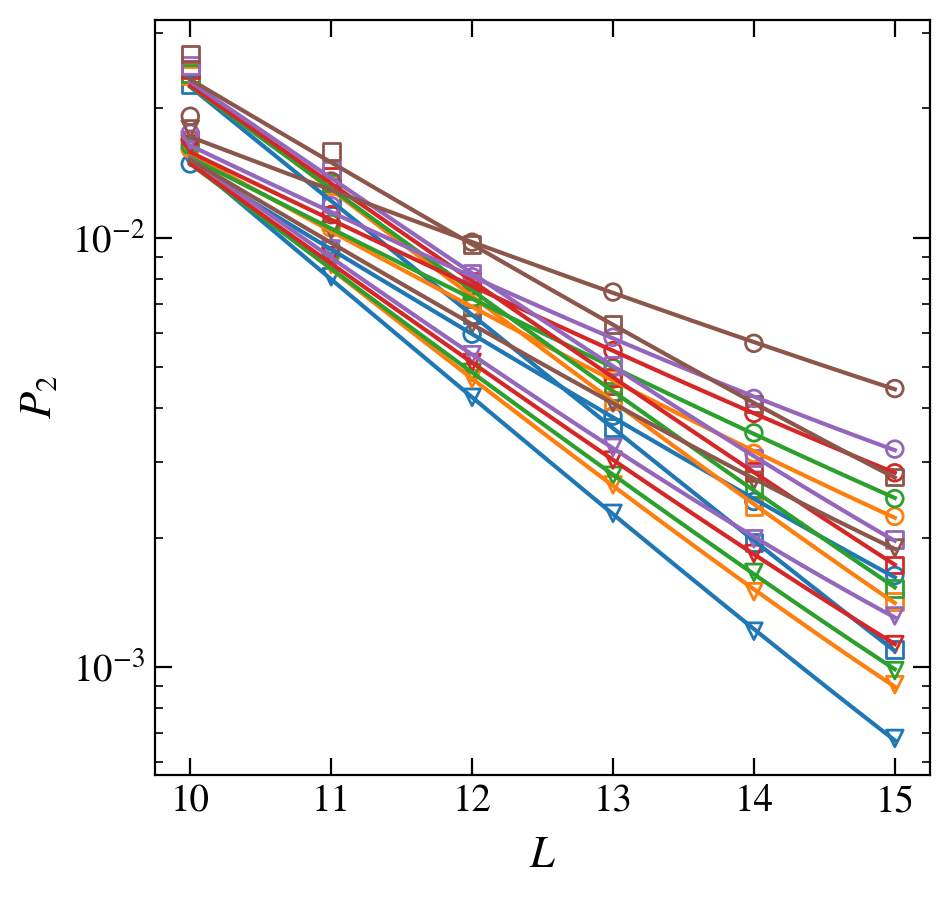

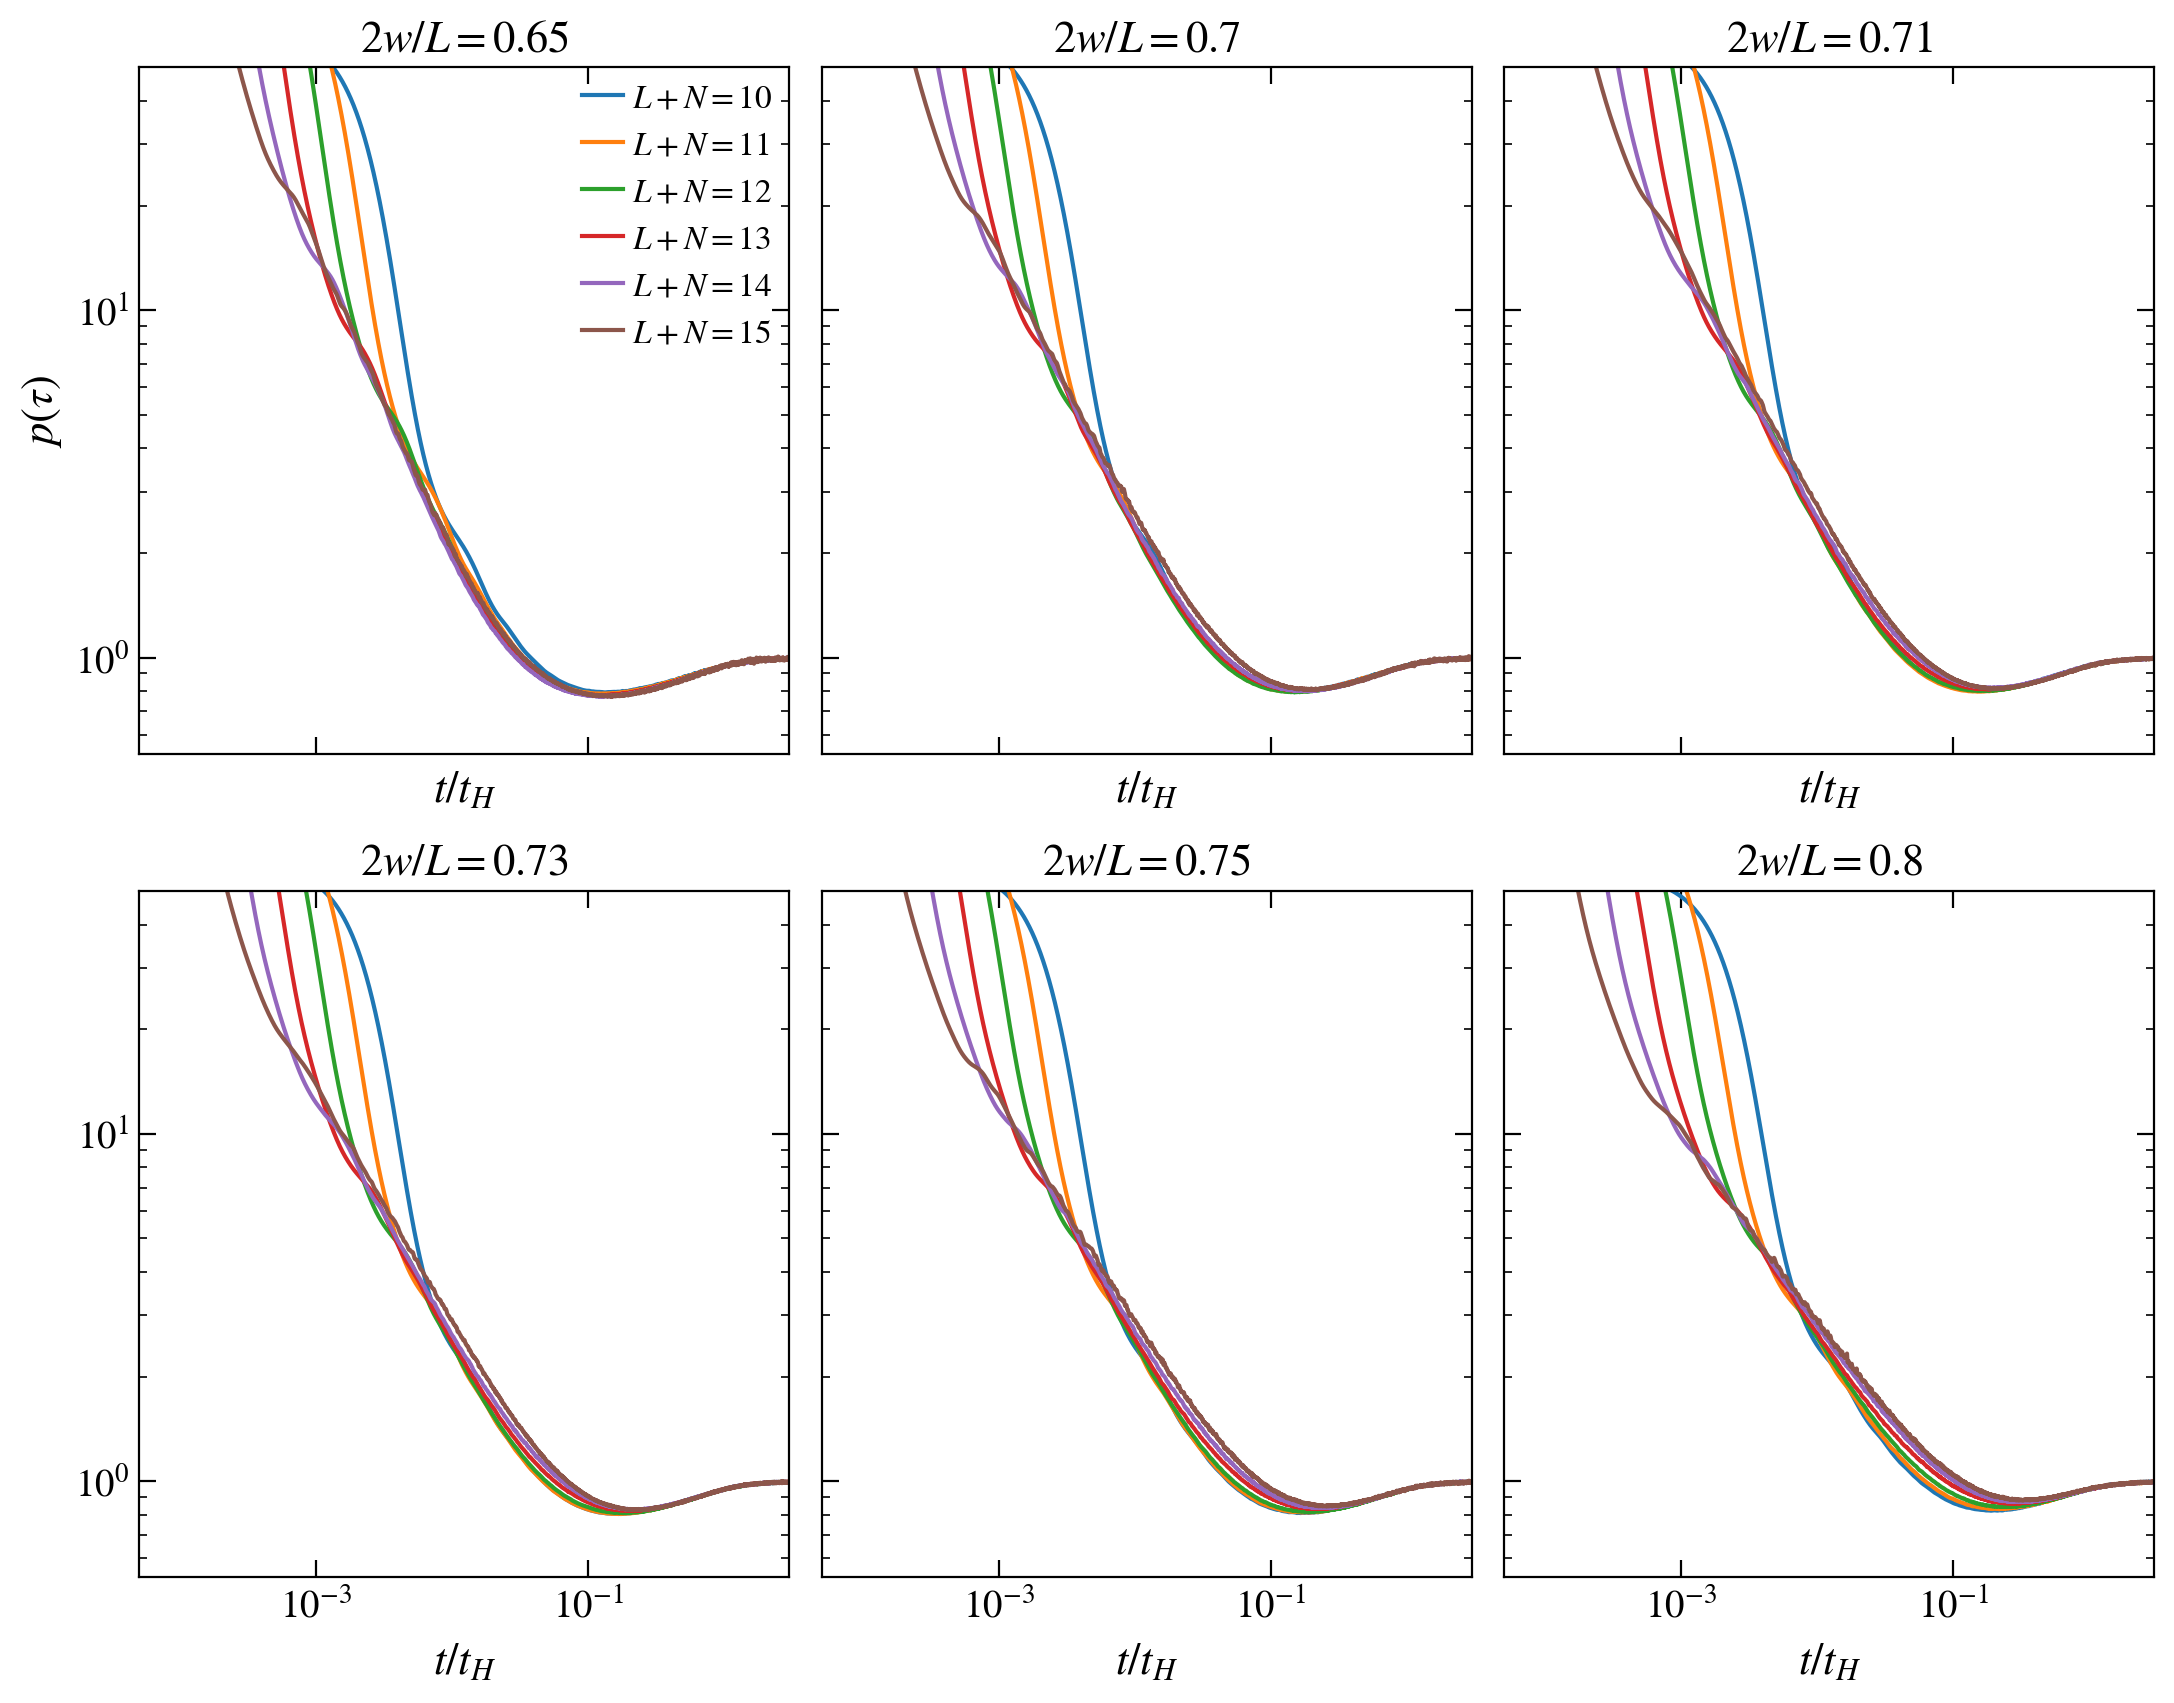

In [5]:
L_total=10
J=1.0
alfa=1.0
h=0.0

w=0.7
plot_derivative = 0
bucket = 0

zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.75, 0.95, 5)
print(w_vals)

sub_sizes = np.arange(0, L+1)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharey=True, sharex=True)
fig, axis = plt.subplots( nrows=2, ncols=3, figsize=(13,10), dpi = 200, sharey=True, sharex=True)
axis = np.array(axis).flatten()

sizes = np.arange(10, 16, 1)

xlab = r"$t$"
def fitta(L, pinf, c, gamma):
    return pinf + c * 2**(-L * gamma)

colors_ls_cyc = itertools.cycle(colors_ls)
for idx, w in enumerate([0.65, 0.70, 0.71, 0.73, 0.75, 0.8]):
    col = next(colors_ls_cyc)
    pr = np.zeros(sizes.shape)
    pr_gauss = np.zeros(sizes.shape)
    pr_proj = np.zeros(sizes.shape)
    for ii_L, L_total in enumerate(sizes):
        L = L_total - N
        name = base_dir + 'SurvivalProbability/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ini_ave=ini_ave, ext='.hdf5', scaled_disorder=scaled_disorder)
        if exists(name):
            with h5py.File(name, "r") as file:
                surv_prob = np.array(file.get('survival'))
                surv_prob_gauss = np.array(file.get('survival gaussian'))
                surv_prob_projected = np.array(file.get('survival projected'))
                if surv_prob.shape == (1, 5000):
                    surv_prob_gauss = surv_prob_gauss[0]
                    surv_prob_projected = surv_prob_projected[0]
                
                pr[ii_L] = np.mean(np.array(file.get('pr')))
                pr_gauss[ii_L] = np.mean(surv_prob_gauss[-50 : -1])
                pr_proj[ii_L] = np.mean(surv_prob_projected[-50 : -1])
        else:
            print(name)
    
    pinf = np.zeros((3))
    mars = ['o', 's', 'v']
    for ii_pr, _pr in enumerate([pr, pr_proj, pr_gauss]):
        pars, pconv = fit(fitta,
                        xdata = sizes[-4:],
                        ydata = _pr[-4:],
                        bounds = ( (0,0,0), (np.inf, np.inf, 3) )
                        )
        ax.scatter(sizes, _pr, label=r"$2w/L=%g$"%w, marker=mars[ii_pr], color=col, facecolor='None')
        aa = np.linspace(sizes[0], sizes[-1], 100)
        ax.plot(aa, fitta(aa, *pars), c=col)

        pinf[ii_pr] = 0#pars[0]
        print(w, pars, pr, fitta(sizes, *pars))
    for ii_L, L_total in enumerate(sizes):
        L = L_total - N
        name = base_dir + 'SurvivalProbability/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ini_ave=ini_ave, ext='.hdf5', scaled_disorder=scaled_disorder)
        if exists(name):
            with h5py.File(name, "r") as file:
                times = np.array(file.get('times'))
                tH_typ = np.array(file.get('tH_typ'))
                
                surv_prob = np.array(file.get('survival'))
                surv_prob_gauss = np.array(file.get('survival gaussian'))
                surv_prob_projected = np.array(file.get('survival projected'))
                # print(L, w, surv_prob.shape)
                if surv_prob.shape == (1, 5000):
                        surv_prob = surv_prob[0]
                        surv_prob_gauss = surv_prob_gauss[0]
                        surv_prob_projected = surv_prob_projected[0]
                        times = times[0]
                if bucket > 1:
                    times = times[bucket//2 : -bucket//2]
                    surv_prob = tools.remove_fluctuations(surv_prob, bucket)[bucket//2 : -bucket//2]
                    surv_prob_gauss = tools.remove_fluctuations(surv_prob_gauss, bucket)[bucket//2 : -bucket//2]
                    surv_prob_projected = tools.remove_fluctuations(surv_prob_projected, bucket)[bucket//2 : -bucket//2]
                
                ydata = (surv_prob - pinf[0]) / (pr[ii_L] - pinf[0])
                ydata = (surv_prob_gauss - pinf[2]) / (pr_gauss[ii_L] - pinf[2])
                # ydata = (surv_prob_projected - pinf[1]) / (pr_proj[ii_L] - pinf[1])
                # axis[idx].plot(times, ydata, label=r"$L+N=%d$"%L_total)
                axis[idx].plot(times / tH_typ, ydata, label=r"$L+N=%d$"%L_total)


    fig_help.set_plot_elements(axis[idx], ylabel=r"$p(\tau)$" if idx == 0 else "", xlabel=r"$t/t_H$", font_size=14, set_legend=False, xscale='log', yscale='log')
    axis[idx].set_title(r"$2w/L=%g$"%w, fontsize=16)
    
fig_help.set_legend(axis[0], loc = 'upper right', fontsize=12)
fig_help.set_plot_elements(ax, ylabel=r"$P_2$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='log')
axis[0].set_xlim(5e-5, 3)
axis[0].set_ylim(None, 5e1)
# for aa in [axis]:
#     for ax in np.array(aa).flatten():
#         ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))


fig.subplots_adjust(wspace = 0.05, hspace=0.2)

[0.75 0.8  0.85 0.9  0.95]
0.75 0 [0.63932751 0.52075367] [0.01749302 0.01186366 0.00810438 0.00585762 0.00421888 0.00321469] [0.01730209 0.01205969 0.0084057  0.00585883 0.00408365 0.00284634]
0.5207536662746958


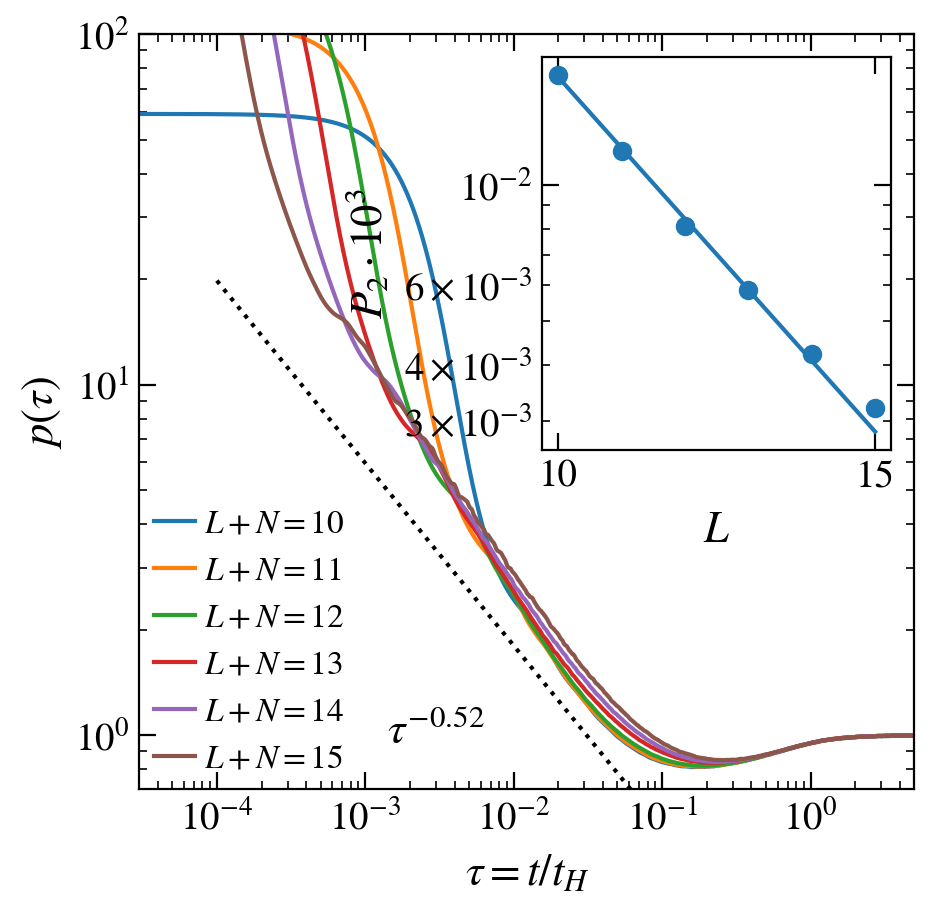

In [7]:
L_total=10
J=1.0
alfa=1.0
h=0.0

w=0.75
plot_derivative = 0
bucket = 10

zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.75, 0.95, 5)
print(w_vals)

sub_sizes = np.arange(0, L+1)
# fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,4), dpi = 200, sharey=True, sharex=True)
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharey=True, sharex=True)
ax = axis.inset_axes([0.52, 0.45, 0.45, 0.52])

sizes = np.arange(10, 16, 1)

xlab = r"$t$"
def fitta(L, c, gamma):
    return c * 2**(-L * gamma)

pr = np.zeros(sizes.shape)
for ii_L, L_total in enumerate(sizes):
    L = L_total - N
    name = base_dir + 'SurvivalProbability/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ini_ave=ini_ave, ext='.hdf5', scaled_disorder=scaled_disorder)
    if exists(name):
        with h5py.File(name, "r") as file:
            pr[ii_L] = np.mean(np.array(file.get('pr')))
    else:
        print(name)

pars, pconv = fit(fitta,
                    xdata = sizes,
                    ydata = pr#,
                    #bounds = ( (0,0,0), (np.inf, np.inf, 0.1) )
                    )
ax.scatter(sizes, pr, label=r"$2w/L=%g$"%w)
aa = np.linspace(sizes[0], sizes[-1], 100)
ax.plot(aa, fitta(aa, *pars))

pinf = 0#pars[0]
D2 = pars[-1]
print(w, pinf, pars, pr, fitta(sizes, *pars))
for ii_L, L_total in enumerate(sizes):
    L = L_total - N
    name = base_dir + 'SurvivalProbability/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ini_ave=ini_ave, ext='.hdf5', scaled_disorder=scaled_disorder)
    if exists(name):
        # print(name)
        with h5py.File(name, "r") as file:
            times = np.array(file.get('times'))
            tH_typ = np.array(file.get('tH_typ'))[0]
            
            surv_prob = np.array(file.get('survival'))
            surv_prob_gauss = np.array(file.get('survival gaussian'))
            surv_prob_projected = np.array(file.get('survival projected'))
            # print(L, w, surv_prob.shape)
            if surv_prob.shape == (1, 5000):
                    surv_prob = surv_prob[0]
                    surv_prob_gauss = surv_prob_gauss[0]
                    surv_prob_projected = surv_prob_projected[0]
                    times = times[0]
            if bucket > 1:
                times = times[bucket//2 : -bucket//2]
                surv_prob = tools.remove_fluctuations(surv_prob, bucket)[bucket//2 : -bucket//2]
                surv_prob_gauss = tools.remove_fluctuations(surv_prob_gauss, bucket)[bucket//2 : -bucket//2]
                surv_prob_projected = tools.remove_fluctuations(surv_prob_projected, bucket)[bucket//2 : -bucket//2]
            
            # ydata = (surv_prob - pinf) / (pr[ii_L] - pinf)
            ydata = (surv_prob_gauss) / (pr[ii_L]); ydata /= ydata[-1]
            axis.plot(times / tH_typ, ydata, label=r"$L+N=%d$"%L_total)
    else:
        print(name)

xx = np.logspace(-4, 2, 1000)
axis.plot(xx, 1.8*(xx/1e-2)**(-D2), ls=':', c='k')
print(D2)
fig_help.set_plot_elements(axis, ylabel=r"$p(\tau)$", xlabel=r"$\tau=t/t_H$", font_size=14, set_legend=False, xscale='log', yscale='log')

fig_help.set_legend(axis, loc = 'lower left', fontsize=12, anchor=(-0.02, -0.02))
fig_help.set_plot_elements(ax, ylabel=r"$P_2\cdot10^3$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='log')

# ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
# ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
# ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
# ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

axis.set_xlim(3e-5, 5)
axis.set_ylim(7e-1, 1e2)
fig.subplots_adjust(wspace = 0.05, hspace=0.2)
axis.annotate(r"$\tau^{-%.2f}$"%D2, fontsize=16, xy=(0.32, 0.06), xycoords='axes fraction')
plt.savefig("plots/Fig3.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("plots/Fig3.png", bbox_inches = 'tight', pad_inches=0.02)

[0.75 0.8  0.85 0.9  0.95]
0.7 0 [4.31210891e-04 1.09170512e+00 6.16650314e-01] [0.01606437 0.01052161 0.00688884 0.00467573 0.00314304 0.00224093] [0.01562979 0.01034347 0.00689582 0.00464732 0.00318089 0.00222451]


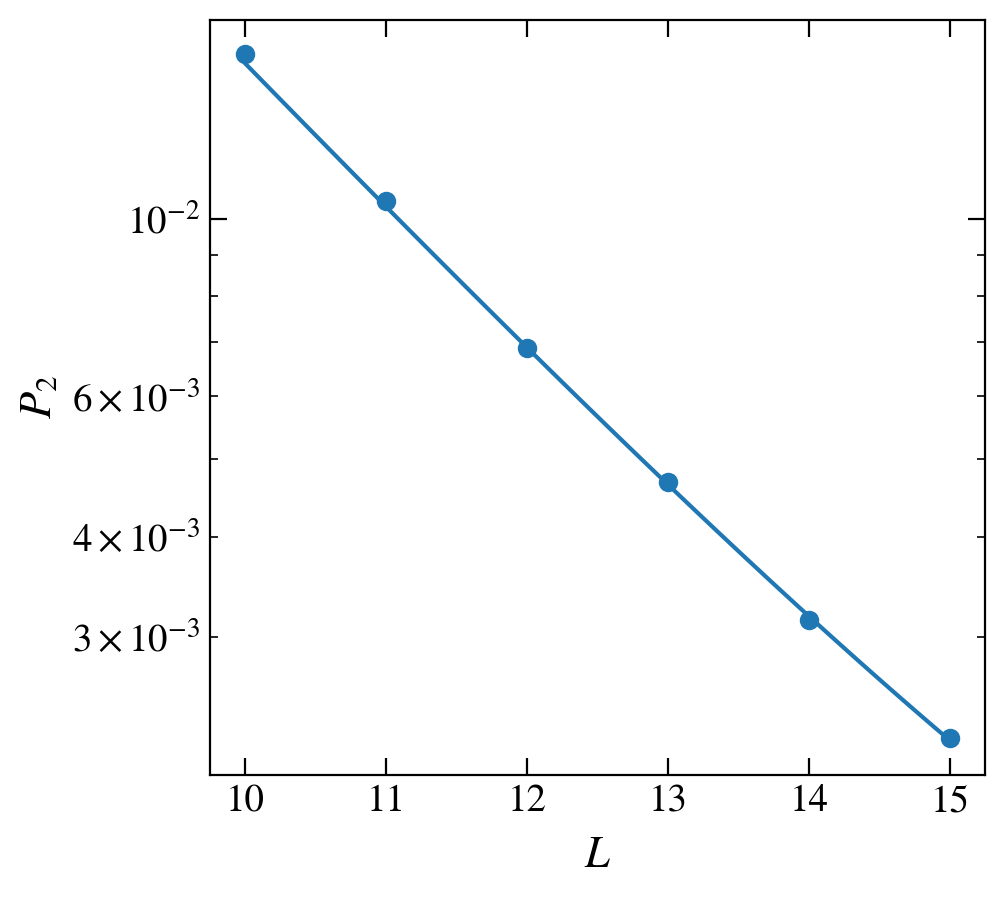

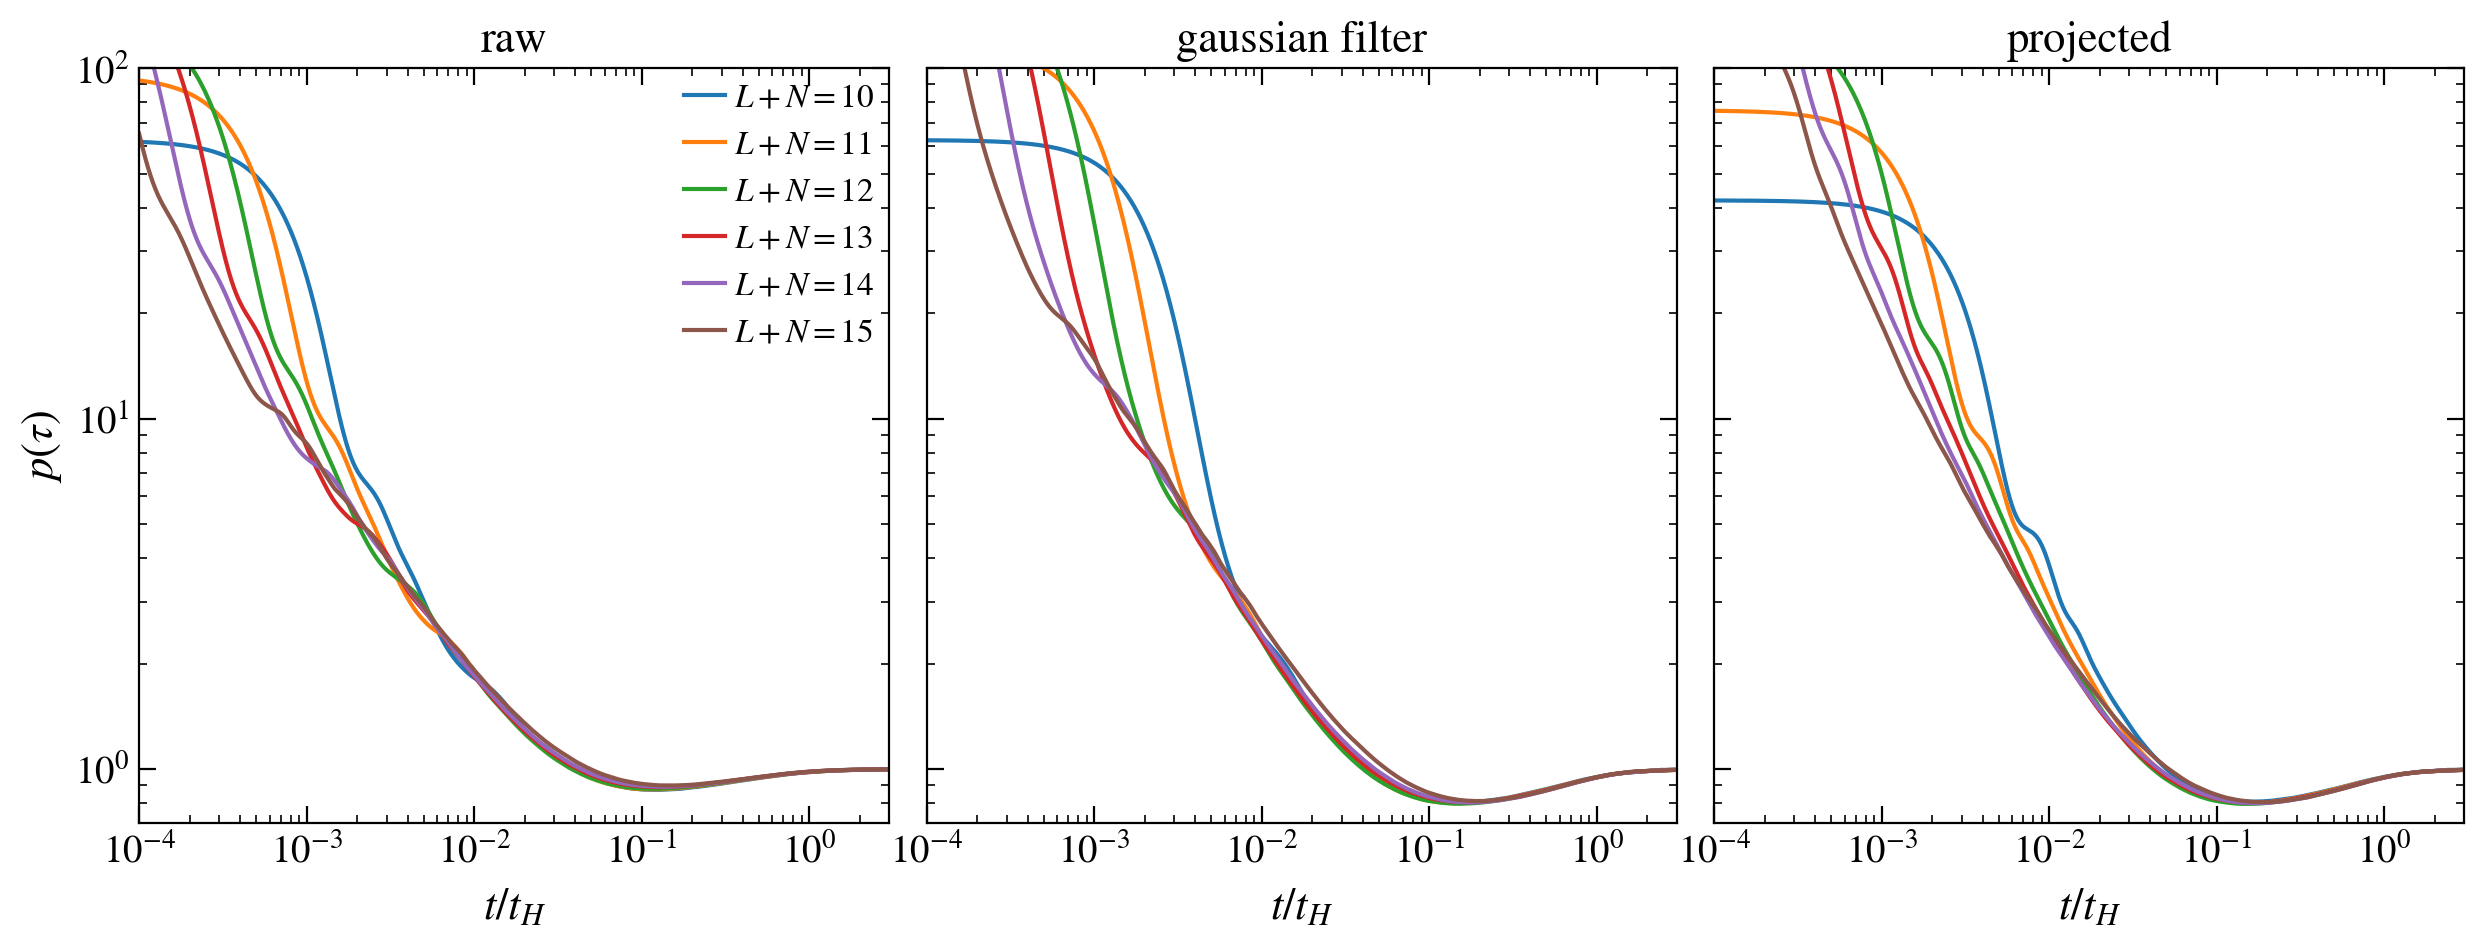

In [325]:
L_total=10
J=1.0
alfa=1.0
h=0.0

w=0.7
plot_derivative = 0
bucket = 50

zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.75, 0.95, 5)
print(w_vals)

sub_sizes = np.arange(0, L+1)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharey=True, sharex=True)
fig, axis = plt.subplots( nrows=1, ncols=3, figsize=(15,5), dpi = 200, sharey=True, sharex=True)

sizes = np.arange(10, 16, 1)

xlab = r"$t$"
def fitta(L, pinf, c, gamma):
    return pinf + c * 2**(-L * gamma)

pr = np.zeros(sizes.shape)
for ii_L, L_total in enumerate(sizes):
    L = L_total - N
    name = base_dir + 'SurvivalProbability/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ini_ave=ini_ave, ext='.hdf5', scaled_disorder=scaled_disorder)
    if exists(name):
        with h5py.File(name, "r") as file:
            pr[ii_L] = np.mean(np.array(file.get('pr')))
    else:
        print(name)

pars, pconv = fit(fitta,
                    xdata = sizes[-4:],
                    ydata = pr[-4:],
                    bounds = ( (0,0,0), (np.inf, np.inf, 2) )
                    )
ax.scatter(sizes, pr, label=r"$2w/L=%g$"%w)
aa = np.linspace(sizes[0], sizes[-1], 100)
ax.plot(aa, fitta(aa, *pars))

pinf = 0#pars[0]
print(w, pinf, pars, pr, fitta(sizes, *pars))
for ii_L, L_total in enumerate(sizes):
    L = L_total - N
    name = base_dir + 'SurvivalProbability/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ini_ave=ini_ave, ext='.hdf5', scaled_disorder=scaled_disorder)
    if exists(name):
        # print(name)
        with h5py.File(name, "r") as file:
            times = np.array(file.get('times'))
            tH_typ = np.array(file.get('tH_typ'))[0]
            
            surv_prob = np.array(file.get('survival'))
            surv_prob_gauss = np.array(file.get('survival gaussian'))
            surv_prob_projected = np.array(file.get('survival projected'))
            # print(L, w, surv_prob.shape)
            if surv_prob.shape == (1, 5000):
                    surv_prob = surv_prob[0]
                    surv_prob_gauss = surv_prob_gauss[0]
                    surv_prob_projected = surv_prob_projected[0]
                    times = times[0]
            if bucket > 1:
                times = times[bucket//2 : -bucket//2]
                surv_prob = tools.remove_fluctuations(surv_prob, bucket)[bucket//2 : -bucket//2]
                surv_prob_gauss = tools.remove_fluctuations(surv_prob_gauss, bucket)[bucket//2 : -bucket//2]
                surv_prob_projected = tools.remove_fluctuations(surv_prob_projected, bucket)[bucket//2 : -bucket//2]
            for idx, ydata in enumerate([surv_prob, surv_prob_gauss, surv_prob_projected]):
                # print(ydata)
                ydata = (ydata) / (pr[ii_L])
                axis[idx].plot(times / tH_typ, ydata / ydata[-1], label=r"$L+N=%d$"%L_total)
            # axis[1].plot(times / tH_typ, (surv_prob_gauss - pinf) / (pr[ii_L] - pinf), label=r"$L+N=%d$"%L_total)
            # axis[2].plot(times / tH_typ, (surv_prob_projected - pinf) / (pr[ii_L] - pinf), label=r"$L+N=%d$"%L_total)
    else:
        print(name)


fig_help.set_plot_elements(axis[0], ylabel=r"$p(\tau)$", xlabel=r"$t/t_H$", font_size=14, set_legend=False, xscale='log', yscale='log')
fig_help.set_plot_elements(axis[1], ylabel="",           xlabel=r"$t/t_H$", font_size=14, set_legend=False, xscale='log', yscale='log')
fig_help.set_plot_elements(axis[2], ylabel="",           xlabel=r"$t/t_H$", font_size=14, set_legend=False, xscale='log', yscale='log')
axis[0].set_title(r"raw", fontsize=16)
axis[1].set_title(r"gaussian filter", fontsize=16)
axis[2].set_title(r"projected", fontsize=16)

fig_help.set_legend(axis[0], loc = 'upper right', fontsize=12)
fig_help.set_plot_elements(ax, ylabel=r"$P_2$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='log')
axis[0].set_xlim(1e-4, 3)
axis[0].set_ylim(7e-1, 1e2)
# for aa in [axis]:
#     for ax in np.array(aa).flatten():
#         ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))


fig.subplots_adjust(wspace = 0.05, hspace=0.2)

[0.65 0.7  0.75 0.8  0.85]


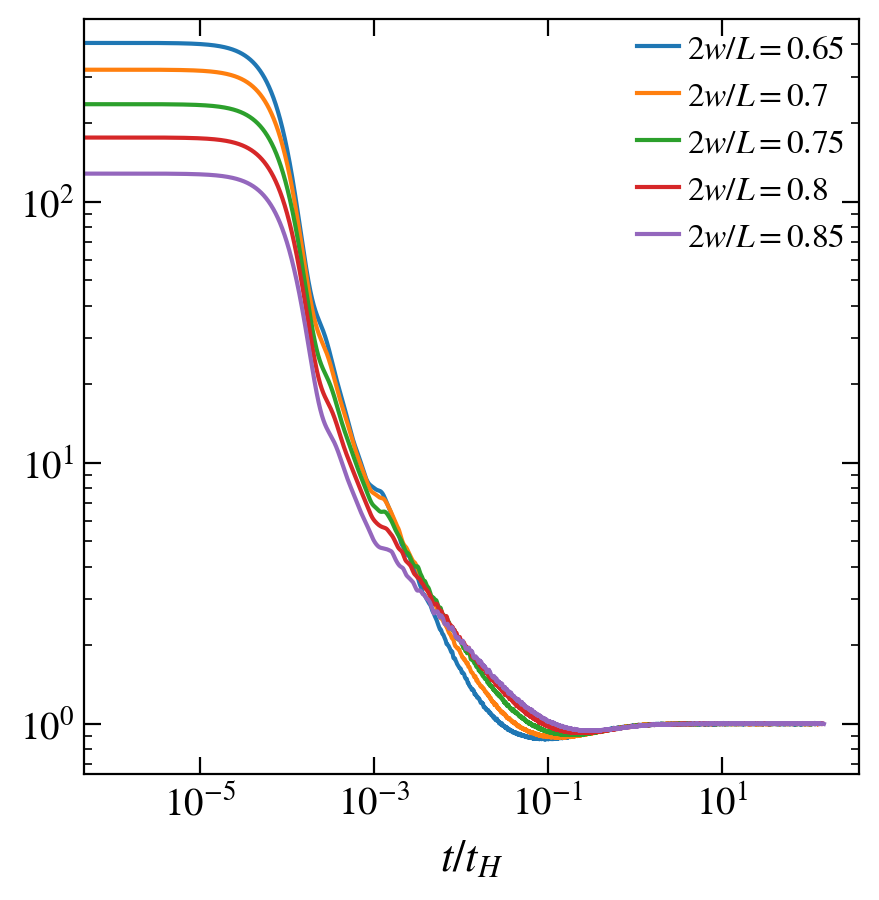

In [306]:
L_total=14
J=1.0
alfa=1.0
h=0.0

w=0.7
plot_derivative = 0
bucket = 0

zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.65, 0.85, 5)
print(w_vals)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharey=True, sharex=True)

sizes = np.arange(8, 14, 1)

xlab = r"$t$"

for idx, w in enumerate(w_vals):
    # for L_total in sizes:
    sub_sizes = np.arange(0, L_total+1)
    L = L_total - N
    LA = L_total // 2

    name = base_dir + 'SurvivalProbability/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ini_ave=ini_ave, ext='.hdf5', scaled_disorder=scaled_disorder)
    if exists(name):
        with h5py.File(name, "r") as file:
            times = np.array(file.get('times'))
            tH_typ = np.array(file.get('tH_typ'))
            pr = np.mean(np.array(file.get('pr')))
            
            surv_prob = np.array(file.get('survival'))
            if bucket > 1:
                times = times[bucket//2 : -bucket//2]
                surv_prob = tools.remove_fluctuations(surv_prob, bucket)[bucket//2 : -bucket//2]
            
            axis.plot(times / tH_typ, surv_prob / pr, label=r"$2w/L=%g$"%w)
    else:
        print(name)


fig_help.set_plot_elements(axis, ylabel=r"$p(\tau)$" if idx == 0 else "", xlabel=r"$t/t_H$", font_size=14, set_legend=False, xscale='log', yscale='log')
fig_help.set_legend(axis, loc = 'upper right', fontsize=12)

# axis[0].set_xlim(1e-1, 1e3)
axis.set_ylim(None, 5e2)
# for aa in [axis]:
#     for ax in np.array(aa).flatten():
#         ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))


fig.subplots_adjust(wspace = 0.05, hspace=0.2)